In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math
import re
import ast
from statsmodels.stats import diagnostic
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency
import json

# Load Data

All data have been merged in Data_merge.ipynb and cleaned in cleaning_data.ipynb

In [3]:
#data_path = './data/'
data_path = ''
data_character = pd.read_csv(data_path + 'clean_data_character.csv')
data_original = pd.read_csv(data_path + 'clean_data_original.csv')
ethnicity_df = pd.read_csv(data_path + 'ethnicity_labels.csv')
data_success = pd.read_csv(data_path + 'clean_data_success.csv')
tropes = pd.read_csv(data_path + 'tvtropes.clusters.txt', sep='\t', header=None, names=['trope', 'data'], engine='python')

# Extract the values inside the second set of quotes for each key-value pair
def extract_values(_str):
    return re.findall(r': "([^"]+)"', _str)

# Apply the extraction function to the relevant columns
data_success['Languages'] = data_success['Languages'].apply(extract_values)
data_success['Countries'] = data_success['Countries'].apply(extract_values)
data_success['Genres'] = data_success['Genres'].apply(extract_values)


In [4]:
# TITLE AND ABSTRACT 

# Representation of Male and Female Actors

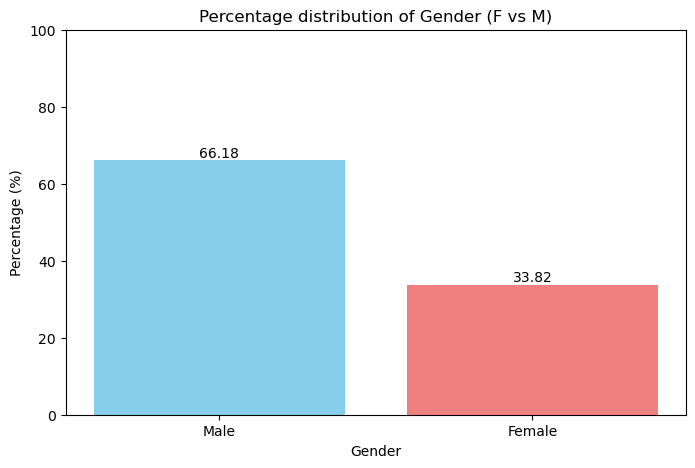

In [5]:
data_character_female = data_character[data_character["actor_gender"] == "F"]
data_character_male = data_character[data_character["actor_gender"] == "M"]
nbre_female = len(data_character_female)
nbre_male = len(data_character_male)
nbre_actors = nbre_male + nbre_female

gender_distrib= {
    'Gender': ['Male', 'Female'],
    'Percentage': [nbre_male*100/nbre_actors , nbre_female*100/nbre_actors]
}
df_gender_distrib = pd.DataFrame(gender_distrib)

plt.figure(figsize=(8, 5))
bars = plt.bar(df_gender_distrib ['Gender'], df_gender_distrib ['Percentage'], color=['skyblue', 'lightcoral'])

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2, 
        height,                            
        f'{height:.2f}',                   
        ha='center',                       
        va='bottom'                         
    )

plt.title('Percentage distribution of Gender (F vs M)')
plt.xlabel('Gender')
plt.ylabel('Percentage (%)')
plt.ylim(0,100)
plt.xticks(rotation=0)
plt.show()

As expected, a significant difference is observed in the number of actors between men and women. Here, men represent 66.18% of the actors, while women account for 33.82%.  
Now, the question is: even if women have always been underrepresented in cinema since its inception, has their representation increased over the years?

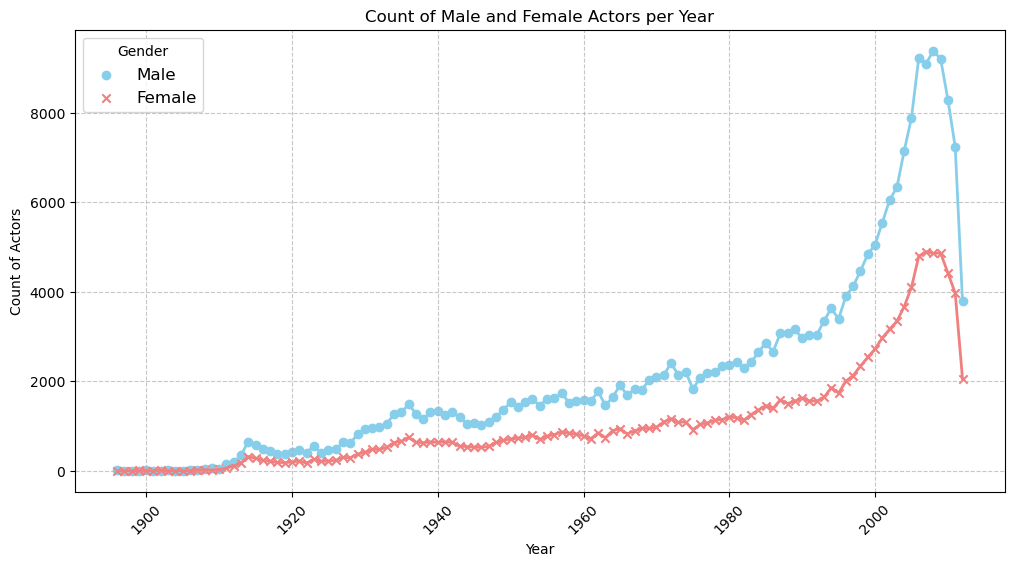

In [6]:
# Grouping data by release year and actor gender
gender_count_per_year = data_character.groupby(['release_year', 'actor_gender']).size().unstack(fill_value=0)

male_counts = gender_count_per_year['M']
female_counts = gender_count_per_year['F']
years = gender_count_per_year.index

plt.figure(figsize=(12, 6))

plt.plot(years, male_counts, color='skyblue', markersize=8, linestyle='-', linewidth=2)
plt.plot(years, female_counts, color='lightcoral', markersize=8, linestyle='-', linewidth=2)

plt.scatter(years, male_counts, color='skyblue', label='Male', marker='o')
plt.scatter(years, female_counts, color='lightcoral', label='Female', marker='x')

plt.title('Count of Male and Female Actors per Year')
plt.xlabel('Year')
plt.ylabel('Count of Actors')

plt.xticks(rotation=45)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(title='Gender', fontsize=12, loc='upper left', frameon=True)

plt.show()

After plotting the number of actors and actresses per year, it appears that their numbers have generally increased over the years for both, but a decline is observed after 2011. This is quite unusual, considering that the cinema industry itself has remained steady.


Upon investigation, we found that the decrease in the number of actors and actresses after 2011 is due to a decline in the number of movies in our dataset during that period. As a result, the number of actors naturally decreases, as shown in the plot below.

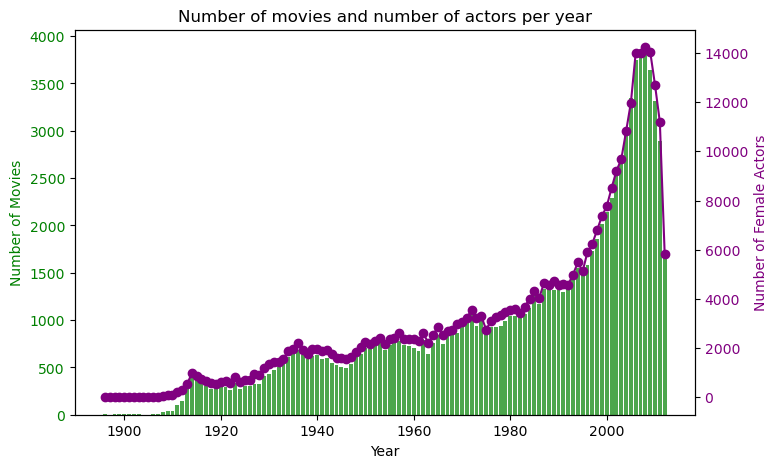

In [7]:
movies_per_year = data_character.groupby('release_year')['Wiki_ID'].nunique()

fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot the number of movies per year
ax1.bar(years, movies_per_year, color='green', label='Number of Movies', alpha=0.7)
ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Movies', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Plot female actors on a secondary axis
ax2 = ax1.twinx()
ax2.plot(years, female_counts + male_counts , color='purple', label='Number of Actors', marker='o')
ax2.set_ylabel('Number of Female Actors', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Number of movies and number of actors per year')
plt.show()

Given that the number of films per year is not consistent, to study the evolution of the number of actors over the years, it would be necessary to divide the number of actors by the number of films each year. This would make the data comparable across years.

Now, the focus is to observe whether the ratio of women to men evolves over the years.

In [8]:
# Calculate the ratio of female actors to movies per year 
ratio_male_to_movie = male_counts / movies_per_year
ratio_female_to_movie = female_counts / movies_per_year

# Calculate the ratio female/male per year 
ratio_female_male = female_counts / male_counts
ratio_female_male[male_counts == 0] = 1

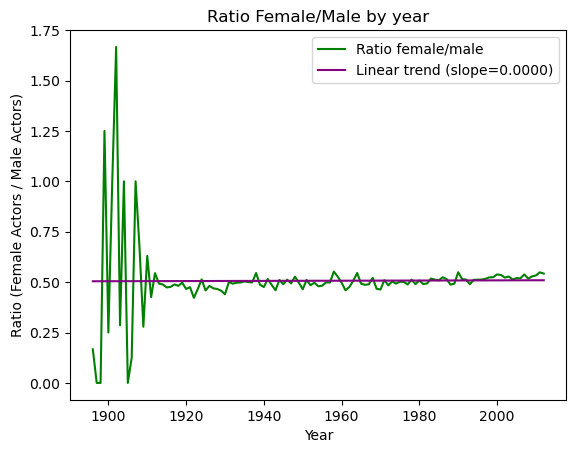

Pearson Correlation Coefficient: 0.0080, p-value: 0.9320845697302564, intercept=0.42


In [9]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(years,ratio_female_male)

sns.lineplot(x=years, y=ratio_female_male, label='Ratio female/male', color = 'green')
plt.plot(years, slope*years+intercept, color='purple',label=f'Linear trend (slope={slope:.4f})')

plt.legend()

plt.title('Ratio Female/Male by year')
plt.xlabel('Year')
plt.ylabel('Ratio (Female Actors / Male Actors)')
plt.show()

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue}, intercept={intercept:.2f}")

As previously observed, the distribution of movies across years is uneven, with some years having significantly fewer movies represented in the dataset. This imbalance can introduce bias when analyzing trends or making comparisons over time. To ensure a more accurate and fair analysis, we limit our focus to years with a minimum of 500 movies. By doing so, we reduce the impact of data sparsity in underrepresented years and provide a more reliable foundation for examining patterns and correlations.

Male Ratio - Pearson Correlation Coefficient: 0.8253, p-value: 2.5876780052741712e-30, intercept=-20.02
Female Ratio - Pearson Correlation Coefficient: 0.7381, p-value: 2.203536060677413e-21, intercept=-11.31


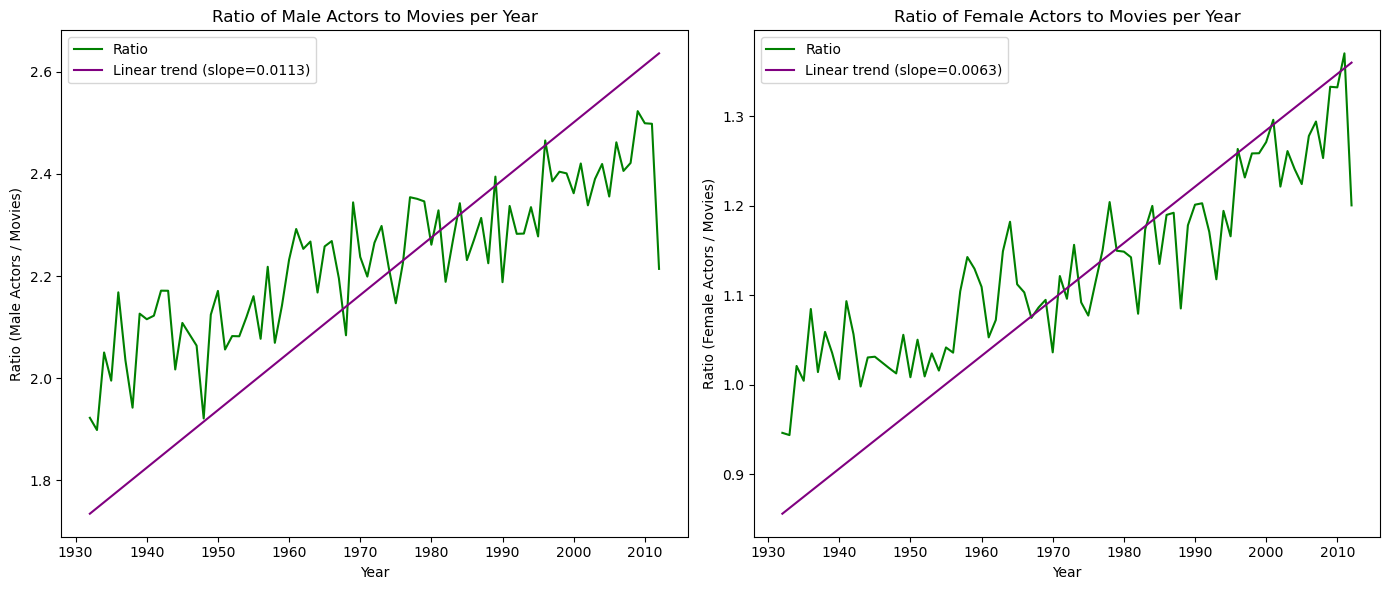

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

slope_male, intercept_male, rvalue_male, pvalue_male, stderr_male = stats.linregress(years, ratio_male_to_movie)

sns.lineplot(x=years[movies_per_year>500], y=ratio_male_to_movie[movies_per_year>500], label='Ratio', color= 'green', ax=axes[0])
axes[0].plot(years[movies_per_year>500], slope_male * years[movies_per_year>500] + intercept_male, color='purple', label=f'Linear trend (slope={slope_male:.4f})')
axes[0].legend()

axes[0].set_title('Ratio of Male Actors to Movies per Year')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Ratio (Male Actors / Movies)')

# Print statistics for Male to movie ratio
print(f"Male Ratio - Pearson Correlation Coefficient: {rvalue_male:.4f}, p-value: {pvalue_male}, intercept={intercept_male:.2f}")

# Female to movie ratio
slope_female, intercept_female, rvalue_female, pvalue_female, stderr_female = stats.linregress(years, ratio_female_to_movie)

sns.lineplot(x=years[movies_per_year>500], y=ratio_female_to_movie[movies_per_year>500], label='Ratio',color = 'green', ax=axes[1])
axes[1].plot(years[movies_per_year>500], slope_female * years[movies_per_year>500] + intercept_female, color='purple', label=f'Linear trend (slope={slope_female:.4f})')
axes[1].legend()

axes[1].set_title('Ratio of Female Actors to Movies per Year')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Ratio (Female Actors / Movies)')

# Print statistics for Female to movie ratio
print(f"Female Ratio - Pearson Correlation Coefficient: {rvalue_female:.4f}, p-value: {pvalue_female}, intercept={intercept_female:.2f}")

plt.tight_layout()
plt.show()

Analysis of the female-to-male ratio in movies over the years reveals that, while the ratio of women to men has remained largely unchanged over the decades, the absolute number of women in films has steadily increased. The linear regression of the ratio over time shows a slope of 0, indicating that the relative representation of women in films has not significantly shifted. However, a closer examination of the raw data reveals a consistent increase in the number of women appearing in movies each year. This suggests that while women's representation in relation to men remains stable, the overall participation of women in the film industry has grown over time.

Women remain underrepresented in cinema, a reality that has inspired various movements to promote gender equality in the industry. 

Another initiative is the Bechdel Test, introduced by Alison Bechdel in 1985. This simple yet powerful tool measures representation by requiring that a film include at least two women who talk to each other about something other than a man. While not comprehensive, the test highlights the widespread lack of meaningful roles for women and has become a key benchmark in discussions about gender equity in cinema.

There is, however, hope for change. Movements like Me Too and Time’s Up have raised awareness and advocated for greater inclusivity in storytelling and casting. Although the male-to-female ratio in the industry has not shifted dramatically, the absolute number of women working in cinema has grown, reflecting slow but steady progress.

Now, attention turns to the Bechdel Test to see if its analysis reveals a trend toward meaningful inclusion of women in film. By studying how movies have performed over time, we can assess whether representation is improving and whether these changes inspire optimism for the future of women in cinema.

# Bechdel test analysis

The Bechdel Test, or Bechdel-Wallace Test, sometimes called the Mo Movie Measure or Bechdel Rule is a simple test 
 which gives a score based on the following three criteria:
 1. it has to have at least two women in it
 2. They talk to each other
 3. They talk about something besides a man.

The test serves as a lens to evaluate whether a film provides meaningful interaction between female characters, reflecting broader trends in the portrayal of women in the film industry.

In this analysis, we will explore how Bechdel Test results have evolved over the years and across different regions of the world. We will also investigate how these scores relate to other aspects of films, such as revenue, ratings, and the presence of female lead actors.

By examining these relationships, our goal is to understand whether the representation of women in cinema has improved over time and whether films that perform well on the Bechdel Test are correlated with greater success. We aim to validate the theory that female representation is becoming more significant in the industry, potentially influencing a film's reception and success.

### Loading Bechdel dataset

The code below is used to get the Bechdel test results from the API and store them in a DataFrame

In [11]:
import requests
url = 'http://bechdeltest.com/api/v1/getAllMovies'

response = requests.get(url)

if response.status_code == 200:
    print('Request was succesful')
    movie_data = response.json()
    df_bechdel = pd.DataFrame(movie_data)
    print(df_bechdel.sample())

else:
    print('Request failed')

df_bechdel.rename(columns={'year':'Year'}, inplace= True)

Request was succesful
       imdbid                            title  rating  year    id
8495  2381991  Huntsman: Winter&#39;s War, The       3  2016  6790


### Bechdel test results along the years

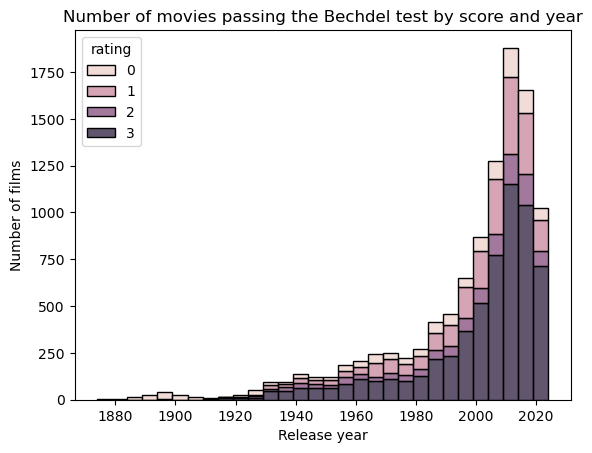

In [12]:
#we here want to plot the number of movies passing the Bechdel test by year and by score
sns.histplot(data=df_bechdel, x='Year', hue='rating',multiple='stack',bins=30)

plt.title('Number of movies passing the Bechdel test by score and year')
plt.xlabel('Release year')
plt.ylabel('Number of films');

We can see that the distribution of data along the years is heavily skewed. Therefore we will plot the proportion of each score among the years.

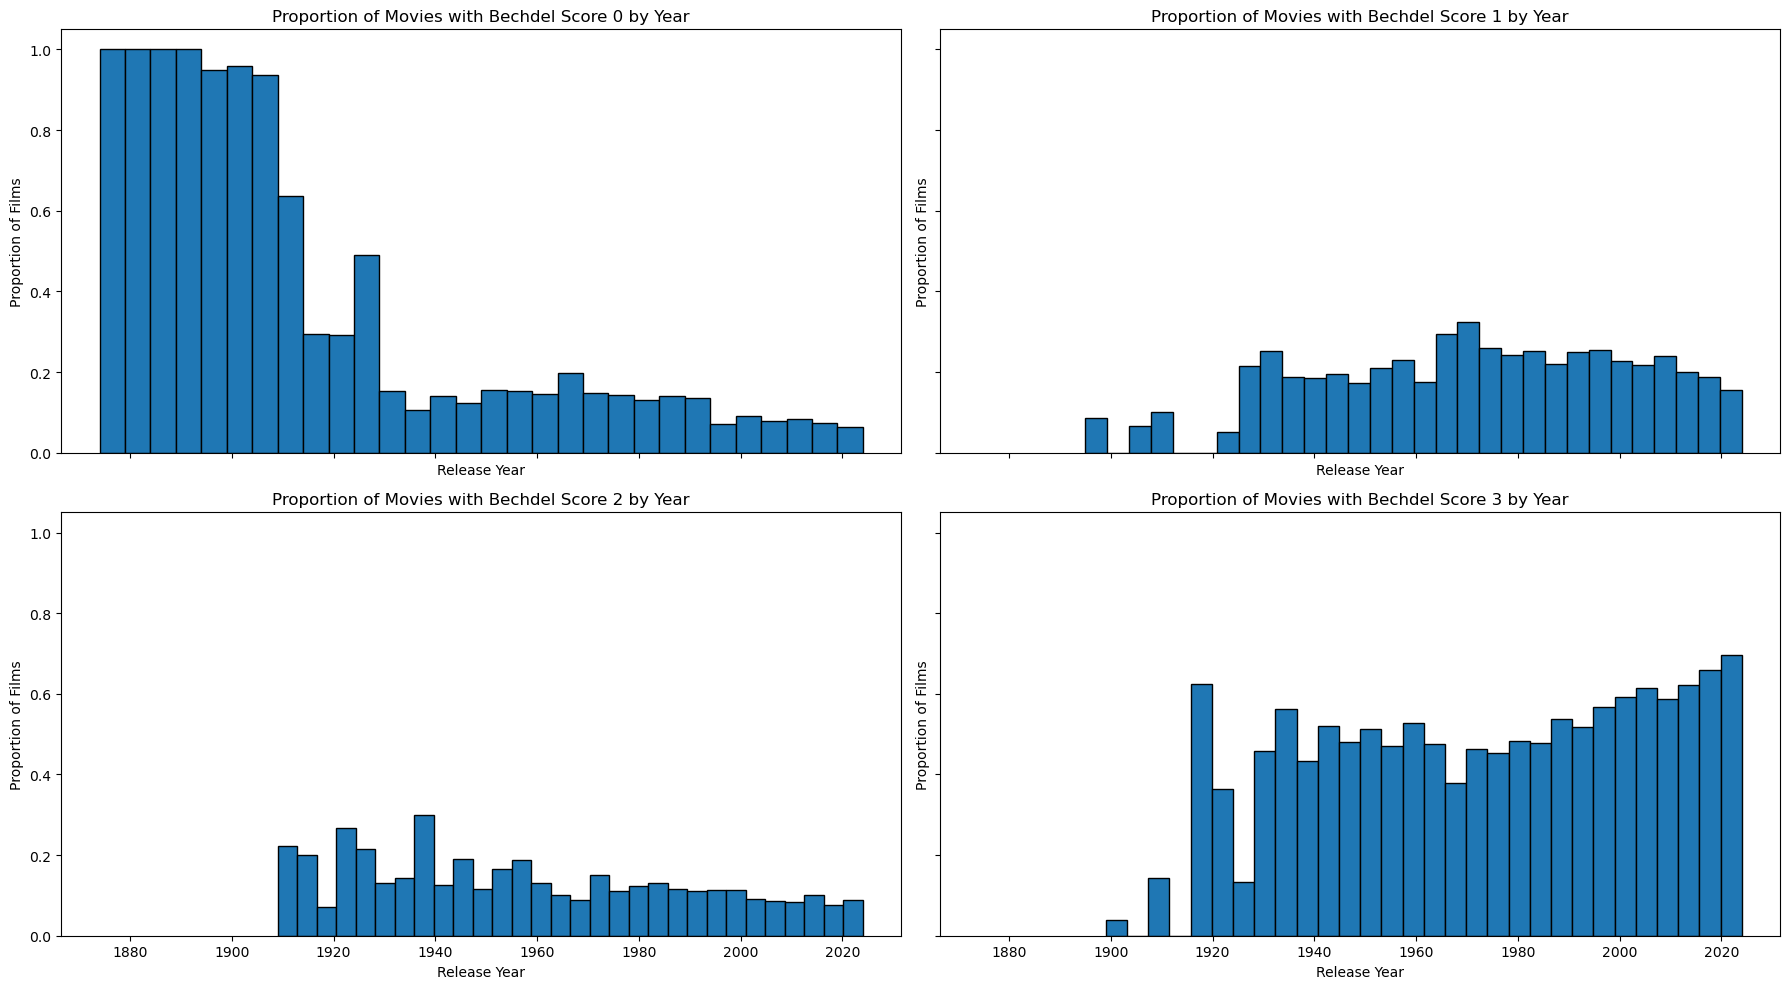

In [13]:
# Define the scores and titles
scores = [0, 1, 2, 3]
titles = [
    "Proportion of Movies with Bechdel Score 0 by Year",
    "Proportion of Movies with Bechdel Score 1 by Year",
    "Proportion of Movies with Bechdel Score 2 by Year",
    "Proportion of Movies with Bechdel Score 3 by Year"
]

fig, axes = plt.subplots(2, 2, figsize=(18, 10), sharex=True, sharey=True)

for i, (score, ax) in enumerate(zip(scores, axes.flatten())):
    # Filter the data for the current score
    filtered_data = df_bechdel.query(f'rating == {score}')
    
    # Create the histogram using numpy to calculate proportions
    counts, bin_edges = np.histogram(filtered_data['Year'], bins=30)
    bin_totals, _ = np.histogram(df_bechdel['Year'], bins=bin_edges)
    proportions = counts / bin_totals  # Normalize by total movies in each bin
    
    # Plot the normalized histogram
    ax.bar(bin_edges[:-1], proportions, width=np.diff(bin_edges), align='edge', edgecolor='black')
    ax.set_title(titles[i])
    ax.set_xlabel('Release Year')
    ax.set_ylabel('Proportion of Films')


plt.tight_layout()
plt.show()


By looking at the scale of the graphs, we can suppose that indeed we now have many more films passing the Bechdel test than failing it. However we have to considert the fact that the data is not equaly distributed along the years. Some proportions are not very representatives because there might not be enough data in the correspinding year. Hence we will only select the years for which we have a minimum of 20 movies.

To investigate this further, we will analyze the correlation between release years and the average Bechdel Test scores. Additionally, we will visualize the trend by plotting the average scores by year, supplemented with a linear regression line to highlight any patterns.

# Group by year and calculate total score and count of movies

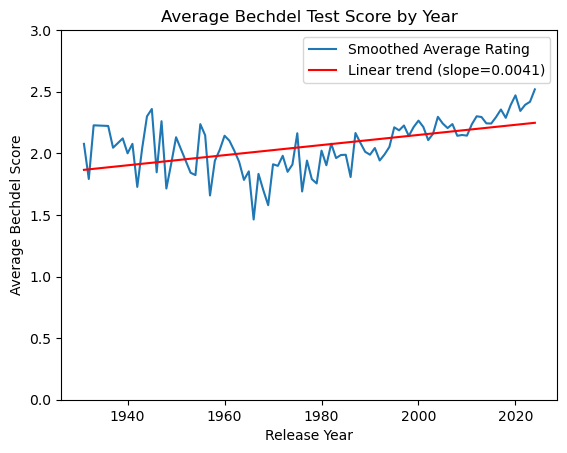

Pearson Correlation Coefficient: 0.5120, p-value: 2.92e-07, intercept: -6.06


In [14]:
# Group by year and calculate total score and count of movies
df_year_stats = df_bechdel.groupby('Year').agg(
    total_score=('rating', 'sum'),
    count=('rating', 'size')
).reset_index()


df_year_stats = df_year_stats[df_year_stats['count'] >= 20]
df_year_stats['avg_bechdel_score'] = df_year_stats['total_score'] / df_year_stats['count']

slope, intercept, rvalue, pvalue, stderr = stats.linregress(df_year_stats['Year'], df_year_stats['avg_bechdel_score'])

sns.lineplot(data=df_year_stats, x='Year', y='avg_bechdel_score', label='Smoothed Average Rating')
plt.plot(df_year_stats['Year'], slope * df_year_stats['Year'] + intercept, color='red', label=f'Linear trend (slope={slope:.4f})')

plt.legend()
plt.title('Average Bechdel Test Score by Year')
plt.xlabel('Release Year')
plt.ylabel('Average Bechdel Score')

plt.ylim(0, 3)

plt.show()

print(f"Pearson Correlation Coefficient: {rvalue:.4f}, p-value: {pvalue:.4g}, intercept: {intercept:.2f}")

Removing data where we have less than 20 movies we reduce our timeline from 1930 to 2024.

By these results, we can observe that the Bechdel test results definitely go up as the years go by. This can be interpreted from our positive slope and our negative intercept in the linear regression. Nevertheless our pearson correlation coefficent tells us that less than half of this increment is due to time passing by, and we should identify other impactful factors.

Lastly, we can affirm that this relationship is most probably not due to randomness, since our p-value is remarkably small.

### Bechdel Test Results in Different World Regions

To analyze how the Bechdel test results have evolved across various world regions, we opted to categorize the films by continent. This approach was chosen to avoid the complexities of geopolitical definitions. By utilizing the pycountry_convert library, we can efficiently convert countries into their respective continents.

For simplicity and based on the assumption that the first country listed in the data is the primary producer or responsible entity for the film, we decided to use only the first country in the list to determine the continent.

In [15]:
import pycountry_convert as pc
#Merging the bechdel dataset with the original datset containing movie
df_movies_bechdel = pd.merge(data_original, df_bechdel, how='inner', on=['title', 'Year'])

df_movies_bechdel['Countries'].value_counts()
df_movies_bechdel = df_movies_bechdel.rename(columns={'rating':'bechdel_score'})
df_movies_bechdel = df_movies_bechdel.drop(columns=['id']) 
df_movies_bechdel = df_movies_bechdel.drop_duplicates(['title','Wiki_ID'])

def get_continent(country_list):
    try:
        country_dict=json.loads(country_list)

        if not country_dict:
            return None

        country_name = list(country_dict.values())[0] #I might need to have different continents! Here I only have the first one!
        country_alpha2=pc.country_name_to_country_alpha2(country_name)
        return pc.country_alpha2_to_continent_code(country_alpha2)
    except KeyError or IndexError:
        return None

df_movies_bechdel['continent']=df_movies_bechdel['Countries'].apply(get_continent)

df_movies_bechdel['continent'].value_counts()

continent
NA    2987
EU     612
AS     186
OC      40
SA       5
AF       2
Name: count, dtype: int64

There is a noticeable underrepresentation of non-North American and non-European films in the Bechdel test database. This disparity can be attributed to the test's popularity being primarily concentrated in North America, with limited focus on international films in the analysis.

For clarity and a more focused visualization, we will restrict the plots to films from North America, Europe, and Asia.

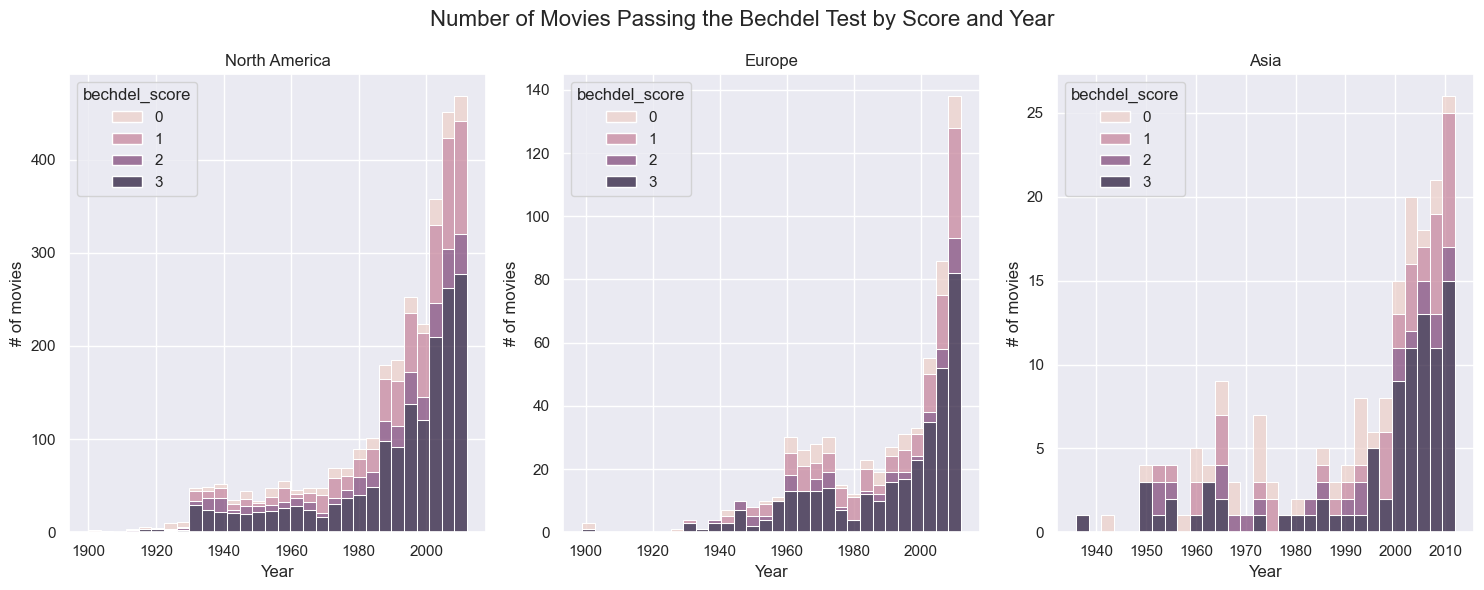

In [16]:
sns.set()

fig, axes = plt.subplots(1,3, figsize = (15,6))

fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'NA'], x='Year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[0]).set(title='North America', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'EU'], x='Year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[1]).set(title='Europe', 
                                                                                                                          ylabel = '# of movies')
sns.histplot(data=df_movies_bechdel[df_movies_bechdel['continent'] == 'AS'], x='Year', hue='bechdel_score', multiple='stack', bins=30, ax=axes[2]).set(title='Asia', 
                                                                                                                          ylabel = '# of movies')

plt.tight_layout();

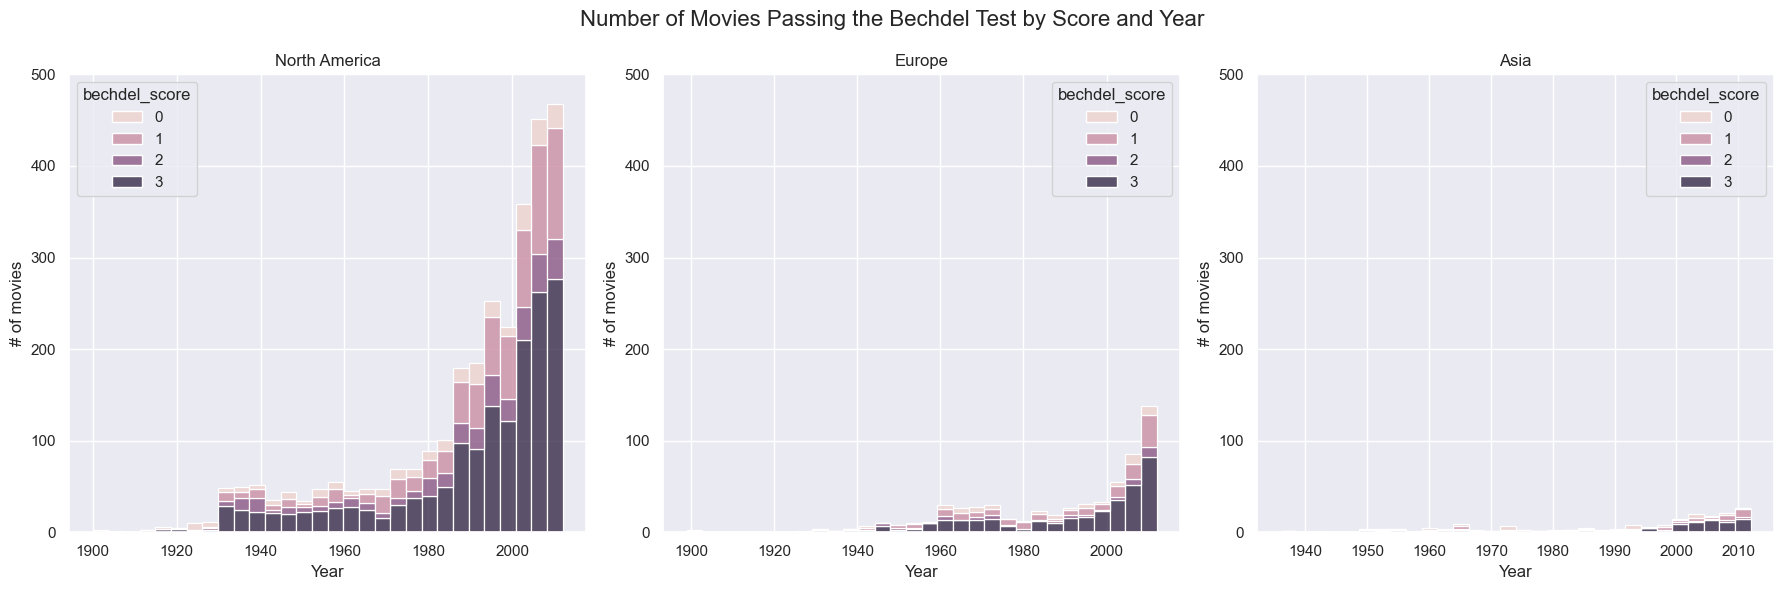

In [17]:
sns.set()

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Number of Movies Passing the Bechdel Test by Score and Year', fontsize=16)

# North America
sns.histplot(
    data=df_movies_bechdel[df_movies_bechdel['continent'] == 'NA'],
    x='Year',
    hue='bechdel_score',
    multiple='stack',
    bins=30,
    ax=axes[0]
).set(title='North America', ylabel='# of movies')
axes[0].set_ylim(0, 500)

# Europe
sns.histplot(
    data=df_movies_bechdel[df_movies_bechdel['continent'] == 'EU'],
    x='Year',
    hue='bechdel_score',
    multiple='stack',
    bins=30,
    ax=axes[1]
).set(title='Europe', ylabel='# of movies')
axes[1].set_ylim(0, 500)

# Asia
sns.histplot(
    data=df_movies_bechdel[df_movies_bechdel['continent'] == 'AS'],
    x='Year',
    hue='bechdel_score',
    multiple='stack',
    bins=30,
    ax=axes[2]
).set(title='Asia', ylabel='# of movies')
axes[2].set_ylim(0, 500)

plt.tight_layout()
plt.show()


We are unable to perform a linear regression for Europe nor Asia  because we are lacking too many data.

Based on this analysis, we can conclude that the results of the Bechdel test have progressively improved over time, reflecting a gradual shift toward more meaningful female representation in films. In the early years of cinema, women were largely excluded from lead roles. 

Now, there is hope for a more inclusive future, with increasing opportunities for women in the industry. So, could women be the future of cinema?

To support casting directors in integrating more women into their films, we propose implementing a predictive model. After thorough analysis, this model would predict the ideal actress who could maximize the success of a film. The model would take inputs such as the film's genre, budget, origin, and Bechdel score, and use these features to predict actress characteristics like height, age, ethnicity, and role type. The goal would be to optimize a metric we will refer to as the "success metric" in order to guide casting decisions more effectively. But first, let's define and implement this success metric.

# Success metric

To determine success metrics for the analysis, IMDb ratings (`Rating`) and box office revenue (`BoxOfficeRevenue`) are utilized. These metrics provide complementary perspectives: IMDb ratings reflect audience and critical reception, offering qualitative insights, while box office revenue quantifies financial performance, delivering measurable data. Together, they form a comprehensive framework for evaluating a movie's overall success and impact.

However, box office revenue only accounts for total earnings and does not consider the production budget, which can lead to biased evaluations. For example, a low-budget film generating three times its cost could be highly profitable but appear less successful in absolute revenue terms compared to a high-budget blockbuster.

To address this, **net box office revenue** ('Net_revenue') is introduced, defined as:  
**Net Box Office Revenue = Box Office Revenue - Initial Budget.**

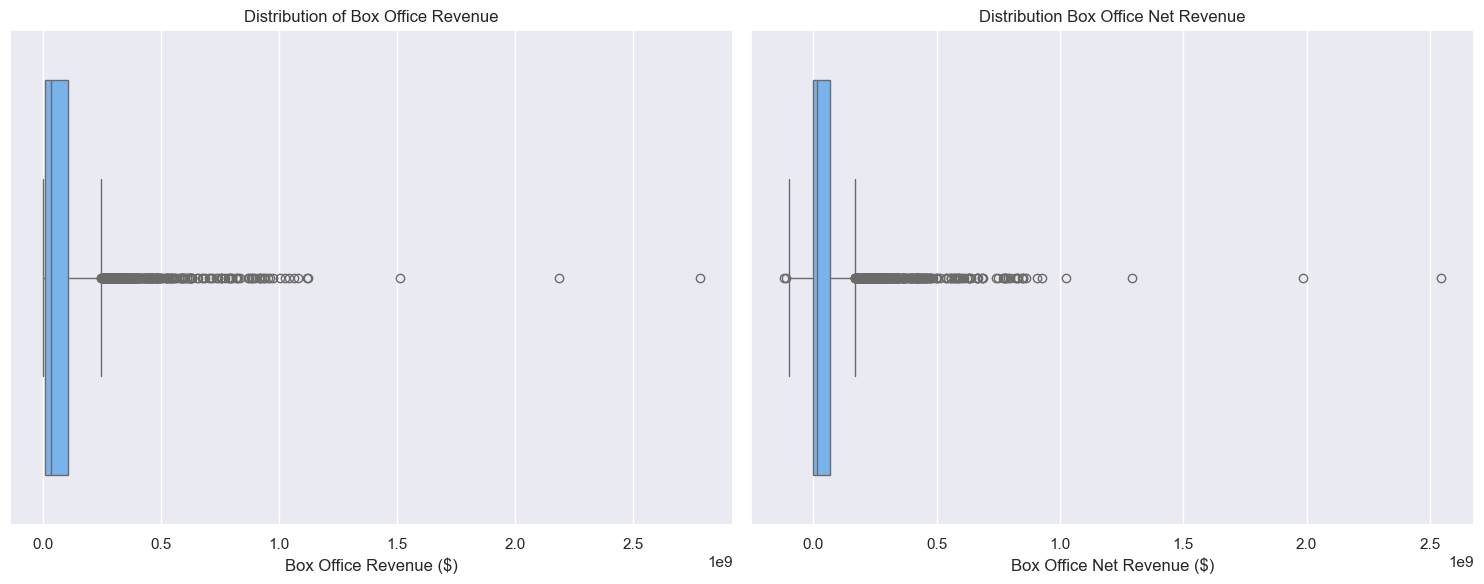

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# First subplot for Box Office Revenue
sns.boxplot(data=data_success, x='BoxOfficeRevenue', color='#66b3ff', ax=axes[0])
axes[0].set_title("Distribution of Box Office Revenue")
axes[0].set_xlabel("Box Office Revenue ($)")

# Second subplot for Net Box Office Revenue
sns.boxplot(data=data_success, x='Net_revenue', color='#66b3ff', ax=axes[1])
axes[1].set_title("Distribution Box Office Net Revenue")
axes[1].set_xlabel("Box Office Net Revenue ($)")

plt.tight_layout()
plt.show()

This adjustment provides a more balanced distribution of financial performance within the metrics, offering a clearer representation of profitability and a fairer comparison across films.

To analyze the success metrics, both IMDb ratings (`Rating`) and net box office revenue were plotted to visually inspect their distributions. This allows for the assessment of whether these metrics require standardization, as the scale and range of the data could impact subsequent analyses. 

By plotting the metrics, a different distribution and scale were observed, indicating that standardization will be required when computing the success metrics.

Using rank normalization to combine box-office net revenue and IMDb ratings ensures a fair and balanced comparison between these two metrics, despite their differences in scale and distribution. By converting raw values into ranks, this approach eliminates the influence of large numerical disparities and focuses on the relative performance within each dataset. This is particularly important when integrating metrics like revenue, which is skewed by a few blockbusters, and ratings, which tend to be more evenly distributed. The result is a unified metric that captures both financial success and audience approval without bias, enabling a comprehensive and equitable evaluation.

In [19]:
data_success['BoxOfficeRank'] = data_success['Net_revenue'].rank(pct=True)
data_success['RatingRank'] = data_success['rating'].rank(pct=True)

To determine the appropriate weight for each metric when combining them, we can plot one against the other (e.g., box-office revenue vs. IMDb rating) to assess their correlation. If the correlation is weak or non-existent, it indicates that the two metrics measure different and independent aspects of success. In such a case, it would be reasonable to assign equal weights (50/50) to each metric, ensuring that neither dominates the combined metric. This approach ensures a balanced representation of both financial performance and audience approval in the final evaluation.

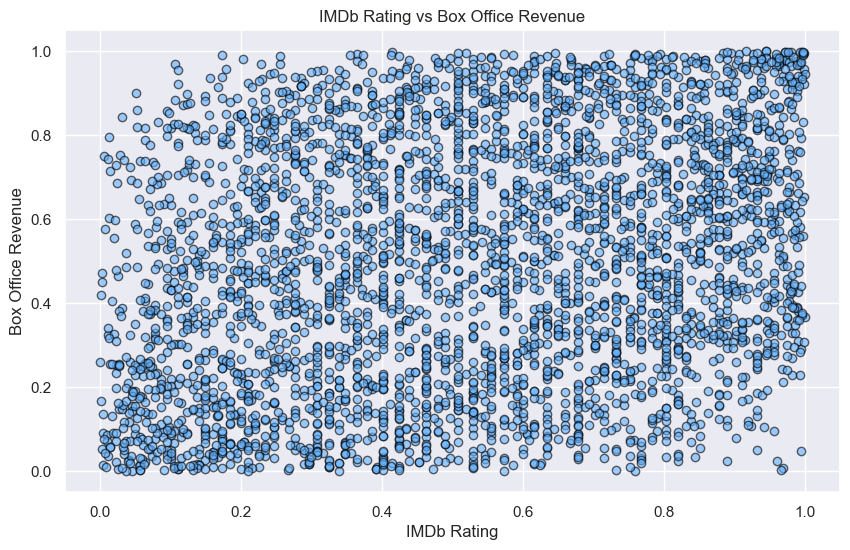

In [20]:
plt.figure(figsize=(10, 6))
plt.scatter(data_success['RatingRank'],data_success['BoxOfficeRank'],  alpha=0.6, color='#66b3ff', edgecolor='black')
plt.title("IMDb Rating vs Box Office Revenue")
plt.ylabel("Box Office Revenue")
plt.xlabel("IMDb Rating")
plt.grid(True)
plt.show()

In [21]:
correlation_rating_revenue = data_success['BoxOfficeRank'].corr(data_success['RatingRank'])
print(f"Correlation between Box Office and IMDb Rating: {correlation_rating_revenue}")

Correlation between Box Office and IMDb Rating: 0.27268199436548246


No significant correlation, we can assign equal weight to both metrics.  
So the metric will be computed like this: **Success Metric = 0.5 * Box Office Net Revenue Rank normalized + 0.5 * Rating Rank normalized .**

In [22]:
weight_box_office = 0.5
weight_imdb = 0.5
data_success['SuccessMetric'] = (weight_box_office * data_success['BoxOfficeRank']) + (weight_imdb * data_success['RatingRank'])

Now that we've defined our success metric, the next step is to examine the relationships and correlations between the various input variables and the success metric. This will help us understand which features are most important for making accurate predictions and guide us in selecting the right inputs for our predictive model.

# Ratio Female/Male correlation 

In [23]:
data_success1 = data_success.copy()

In [24]:
data_success1['num_actors'] = data_success1['Movie_ID'].map(
                                                    data_character.groupby('Movie_ID')['Actor_ID'].nunique()
                                                    )

data_success1['num_women'] = data_success1['Movie_ID'].map(
                                                    data_character[data_character['actor_gender']=='F'].groupby('Movie_ID')['Actor_ID'].nunique()
                                                )

data_success1 = data_success1.dropna(subset=['num_actors', 'num_women', 'SuccessMetric'])

data_success1['ratio_W/M'] = np.where(data_success1['num_actors'] == 0, 1, data_success1['num_women'] / data_success1['num_actors'])

#correlation3 = data_success['SuccessMetric'].corr(data_success['ratio_W/M'])
# Drop rows with NaN values in relevant columns

# Compute correlation between SuccessMetric and the ratio of women to men
correlation_success_ratiomf = data_success1['SuccessMetric'].corr(data_success1['ratio_W/M'])

In [25]:
print(f"Correlation between the Ratio Female/Male and SuccessMetric: {correlation_success_ratiomf}")

Correlation between the Ratio Female/Male and SuccessMetric: -0.06281659095098419


There is no evident link between the two variables. The correlation is very low, the two variables are not correlated.

In [26]:
data_corr_genre = data_success1.copy()

corr_analysis = data_corr_genre.groupby('Movie_ID').agg(
                                                    SuccessMetric=('SuccessMetric', 'first'),
                                                    ratio_W_M = ('ratio_W/M', 'first'),
                                                    Genres = ('Genres','first')
                    
                                                ).reset_index()

In [27]:
from scipy.stats import ttest_ind

# Initialize a list to store the results
results_list = []

# Get the list of unique ethnic categories (excluding NaNs)
all_genres_cats = pd.Series([genre for sublist in corr_analysis['Genres'] for genre in sublist if pd.notna(genre)]).unique()

# Iterate through each ethnic category
for genre_cat in all_genres_cats:
    # Filter out movies that include this ethnic category
    movies_with_genre_cat = corr_analysis[corr_analysis['Genres'].apply(lambda x: isinstance(x, list) and genre_cat in x)]
    movies_without_genre_cat = corr_analysis[corr_analysis['Genres'].apply(lambda x: isinstance(x, list) and genre_cat not in x)]
    
    if len(movies_with_genre_cat) < 100 or len(movies_without_genre_cat) < 100:
        continue

    # Calculate mean success scores
    mean_with = movies_with_genre_cat['SuccessMetric'].mean()
    mean_without = movies_without_genre_cat['SuccessMetric'].mean()
    
    
    # Check for low variance or insufficient unique values
    if movies_with_genre_cat['SuccessMetric'].nunique() < 2 or movies_with_genre_cat['SuccessMetric'].nunique() < 2:
        t_stat, p_value = np.nan, np.nan
    else:
    # Perform a t-test
        t_stat, p_value = ttest_ind(
            movies_with_genre_cat['SuccessMetric'].dropna(),
            movies_without_genre_cat['SuccessMetric'].dropna(),
            equal_var=False
        )

    # Store the results
    results_list.append({
        'genre_cat': genre_cat,
        'mean_with_genre_cat': mean_with,
        'mean_without_genre_cat': mean_without,
        'mean_diff': mean_with - mean_without,
        't_stat': t_stat,
        'p_value': p_value,
        'nb_movies_with':  len(movies_with_genre_cat),
        'nb_movies_without': len(movies_without_genre_cat),
    })

# Create a DataFrame from the results list
results_df = pd.DataFrame(results_list)

# Sort the results by p-value
results_df = results_df.sort_values(by='p_value')

# Display the results
results_df.head(10)

,genre_cat,mean_with_genre_cat,mean_without_genre_cat,mean_diff,t_stat,p_value,nb_movies_with,nb_movies_without
5,Drama,0.548037,0.478354,0.069683,9.160472,8.618828e-20,1744,1740
36,Animation,0.619674,0.507164,0.112509,6.390681,1.074001e-09,188,3296
9,Comedy,0.487680,0.530058,-0.042378,-5.412328,6.717763e-08,1383,2101
29,Horror,0.465563,0.520037,-0.054474,-5.061149,5.559754e-07,435,3049
24,War film,0.596389,0.509207,0.087182,4.833476,2.905837e-06,161,3323
37,Slasher,0.434352,0.516049,-0.081698,-4.879027,2.991749e-06,120,3364
6,Film adaptation,0.569351,0.507541,0.061810,4.573821,6.467793e-06,321,3163
15,Costume drama,0.607886,0.509625,0.098261,4.664784,7.295368e-06,128,3356
22,Biography,0.594058,0.510203,0.083855,4.376565,2.382147e-05,126,3358
16,Period piece,0.563971,0.507998,0.055973,4.223318,2.992481e-05,326,3158


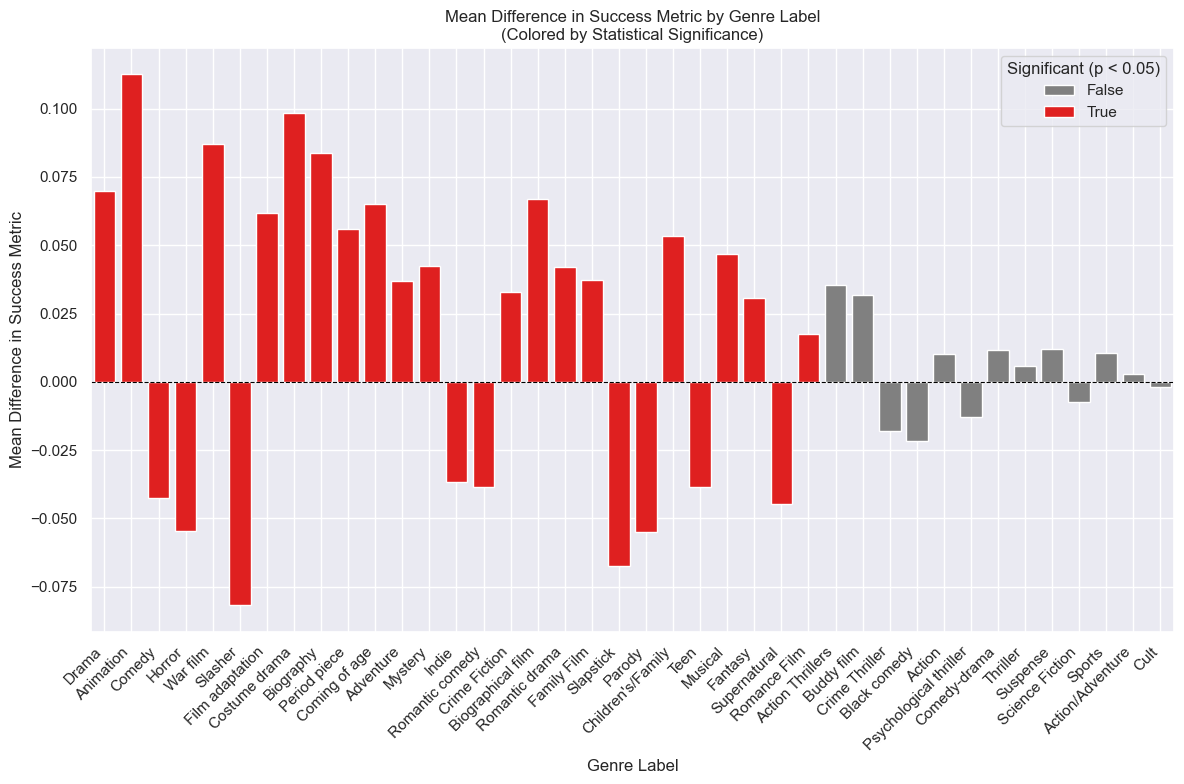

In [28]:
filtered_results_df = results_df.dropna(subset=['p_value'])
filtered_results_df['Significant'] = filtered_results_df['p_value'] < 0.05

plt.figure(figsize=(12, 8))
sns.barplot(
    data=filtered_results_df,
    x='genre_cat', y='mean_diff',
    hue='Significant',
    palette={True: 'red', False: 'gray'}
)

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel("Genre Label")
plt.ylabel("Mean Difference in Success Metric")
plt.title("Mean Difference in Success Metric by Genre Label\n(Colored by Statistical Significance)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Significant (p < 0.05)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Ethnicity correlation

Create a numerical categorical variable associated with the different ethnicities

In [29]:
ethnicity_df['ethnic_cat'] = ethnicity_df.index
data_character = pd.merge(data_character, ethnicity_df[['ethnicity_ID', 'ethnic_cat']], on='ethnicity_ID', how='left')

Add a line with the ratio of Women within the main actors in the films

In [30]:
data_success['num_actors'] = data_success['Movie_ID'].map(data_character.groupby('Movie_ID')['Actor_ID'].nunique())
data_success['num_women'] = data_success['Movie_ID'].map(data_character[data_character['actor_gender']=='F'].groupby('Movie_ID')['Actor_ID'].nunique())
data_success['ratio_W/M'] = data_success['num_women']/data_success['num_actors']

In [31]:
women_data = data_character[data_character['actor_gender']=='F'].copy()
men_data = data_character[data_character['actor_gender']=='M'].copy()

We will only consider the ethnicities for which we have a minimum of 30 different actors. Else, it doesn't seem to be enough to draw any conclusions.

In [32]:
low_count_ethnicities = ethnicity_df.loc[ethnicity_df['count'] < 30, 'ethnic_cat'].tolist()
women_data_ethnicity = women_data.copy()
women_data_ethnicity['ethnic_cat'] = women_data['ethnic_cat'].apply(lambda x: pd.NA if x in low_count_ethnicities else x)

We will keep only movies with at least 4 actors and 10% actress since we are focusing on actress.

In [33]:
valid_mask = (data_success['ratio_W/M'] >= 0.1) & (data_success['num_actors'] > 4)
movies_women = data_success[valid_mask].copy()

In [34]:
analysis = pd.merge(
                        women_data_ethnicity[['actor_age_movie_released', 'Movie_ID', 'actor_name', 'ethnic_cat', 'actor_height']],
                        movies_women.dropna(subset=['SuccessMetric'])[['title', 'SuccessMetric', 'Movie_ID', 'ratio_W/M', 'rating']],
                        on='Movie_ID',
                        how = 'inner'
                        )

mean_women_data = analysis.groupby('Movie_ID').agg(
                                                    mean_age=('actor_age_movie_released', 'median'),
                                                    num_women=('actor_age_movie_released', 'size'),
                                                    title=('title', 'first'),
                                                    SuccessMetric=('SuccessMetric', 'first'),
                                                    ratio_W_M = ('ratio_W/M', 'first'),
                                                    ethnicities = ('ethnic_cat', lambda x: [eth for eth in x if pd.notna(eth)]),
                                                    avg_height = ('actor_height', 'mean'),
                                                    Rating = ('rating', 'first')
                                                ).reset_index()
print(f"The total number of movies with a success metrics is {mean_women_data.shape[0]}.")

The total number of movies with a success metrics is 3277.


We will remove movies with less than 30 different movies.

In [35]:
ethnicity_counts = pd.Series([eth for sublist in mean_women_data['ethnicities'] for eth in sublist if pd.notna(eth)]).value_counts()
valid_ethnicities = ethnicity_counts[ethnicity_counts >= 30].index

mean_women_data['ethnicities'] = mean_women_data['ethnicities'].apply(
    lambda eth_list: [eth for eth in eth_list if eth in valid_ethnicities]
)

mean_women_data_ethnicity = mean_women_data[mean_women_data['ethnicities'].apply(len) > 0]

print(f"The total number of movies with a success metrics and enough ethnicities is {mean_women_data_ethnicity.shape[0]}.")


The total number of movies with a success metrics and enough ethnicities is 2149.


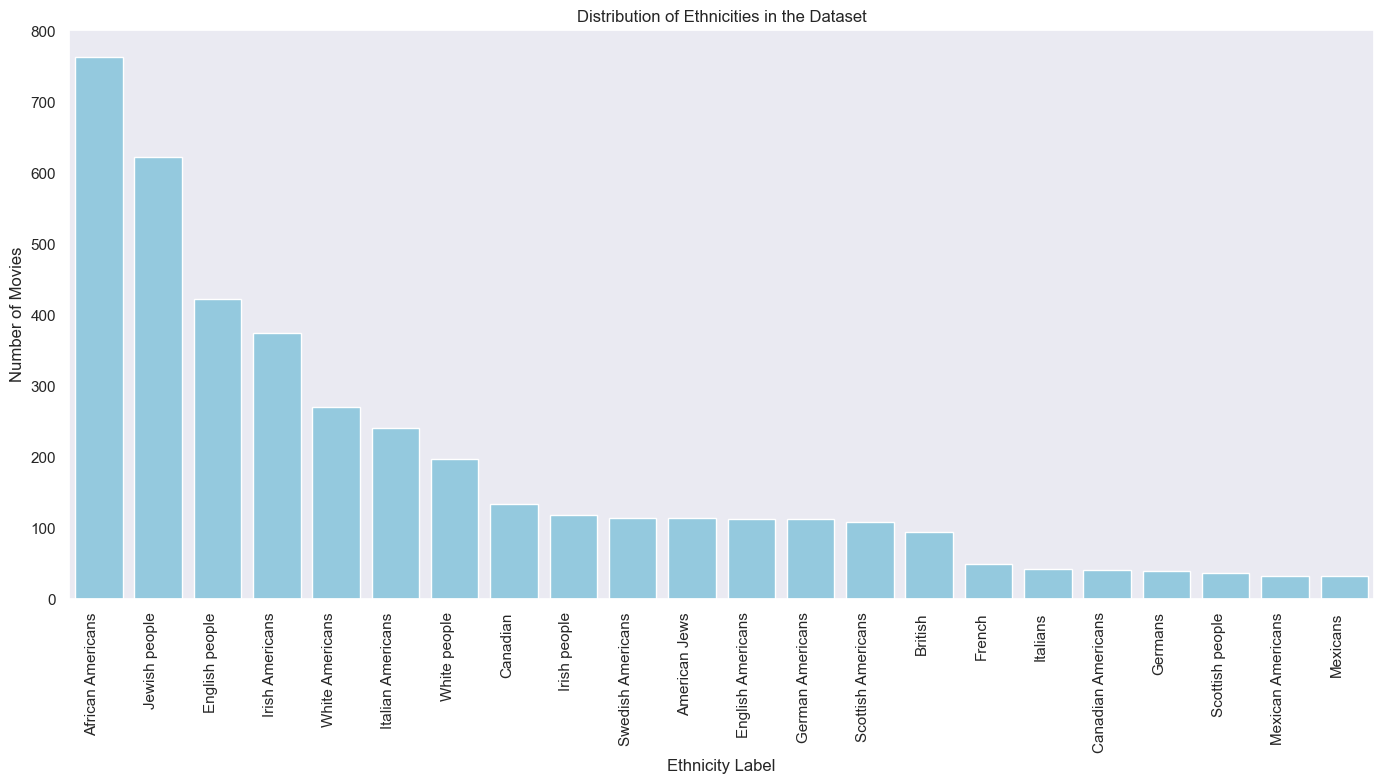

In [36]:
ethnicity_counts = pd.Series([eth for sublist in mean_women_data_ethnicity['ethnicities'] for eth in sublist if pd.notna(eth)])
ethnicity_distribution = ethnicity_counts.value_counts().reset_index()
ethnicity_distribution.columns = ['ethnic_cat', 'count']

ethnicity_distribution = pd.merge(
    ethnicity_distribution,
    ethnicity_df[['ethnic_cat', 'ethnicity_label']],
    on='ethnic_cat',
    how='left'
)

ethnicity_distribution = ethnicity_distribution.sort_values(by='count', ascending=False)

plt.figure(figsize=(14, 8))
sns.barplot(x='ethnicity_label', y='count', data=ethnicity_distribution, color='skyblue')
plt.title("Distribution of Ethnicities in the Dataset")
plt.xlabel("Ethnicity Label")
plt.ylabel("Number of Movies")
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


The distribution of the data on the different ethnicities is not equally distributed at all. We will have to be carefull with this.

# Establish relationship between ethnicities and SuccessMetric

We looked at the difference of mean success metrics between movies containing at least one actress from an ethnicity compared to all other movies. Then we performed a t-test using equal_var=False to compensate the fact that the distribution is not even for every ethnicity.

In [37]:
results_list = []

# Get the list of unique ethnic categories
all_ethnic_cats = pd.Series([eth for sublist in mean_women_data_ethnicity['ethnicities'] for eth in sublist if pd.notna(eth)]).unique()


for ethnic_cat in all_ethnic_cats:
    # Filter out movies that include this ethnic category
    movies_with_ethnic_cat = mean_women_data_ethnicity[mean_women_data_ethnicity['ethnicities'].apply(lambda x: isinstance(x, list) and ethnic_cat in x)]
    movies_without_ethnic_cat = mean_women_data_ethnicity[mean_women_data_ethnicity['ethnicities'].apply(lambda x: isinstance(x, list) and ethnic_cat not in x)]

    if len(movies_with_ethnic_cat) < 2 or len(movies_without_ethnic_cat) < 2:
        print(f"Not enough movies for comparison for ethnicity: {ethnic_cat}")
        continue
    
    # Calculate mean success scores on each group
    mean_with = movies_with_ethnic_cat['SuccessMetric'].mean()
    mean_without = movies_without_ethnic_cat['SuccessMetric'].mean()
    
    # Check for low variance or insufficient unique values
    if movies_with_ethnic_cat['SuccessMetric'].nunique() < 2 or movies_without_ethnic_cat['SuccessMetric'].nunique() < 2:
        t_stat, p_value = np.nan, np.nan
    else:
        t_stat, p_value = ttest_ind(
            movies_with_ethnic_cat['SuccessMetric'].dropna(),
            movies_without_ethnic_cat['SuccessMetric'].dropna(),
            equal_var=False
        )
    
    results_list.append({
        'ethnic_cat': ethnic_cat,
        'nb_movies_with':  len(movies_with_ethnic_cat),
        'nb_movies_without': len(movies_without_ethnic_cat),
        'mean_diff': mean_with - mean_without,
        'mean_with_ethnic_cat': mean_with,
        'mean_without_ethnic_cat': mean_without,
        't_stat': t_stat,
        'p_value': p_value
    })


results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='p_value')


In [38]:
results_df.head(8)

,ethnic_cat,nb_movies_with,nb_movies_without,mean_diff,mean_with_ethnic_cat,mean_without_ethnic_cat,t_stat,p_value
1,24.0,314,1835,0.062532,0.569987,0.507455,4.377817,0.000015
8,113.0,35,2114,0.154195,0.668275,0.514081,4.369022,0.000104
7,7.0,111,2038,-0.052965,0.466363,0.519328,-2.158326,0.032895
4,75.0,86,2063,0.055050,0.569439,0.514389,2.123703,0.036383
5,3.0,543,1606,-0.019150,0.502281,0.521431,-1.716443,0.086399
2,48.0,245,1904,0.025585,0.539260,0.513675,1.695429,0.090978
6,25.0,115,2034,0.037193,0.551795,0.514602,1.657725,0.099847
10,0.0,125,2024,-0.033394,0.485141,0.518534,-1.654177,0.100306


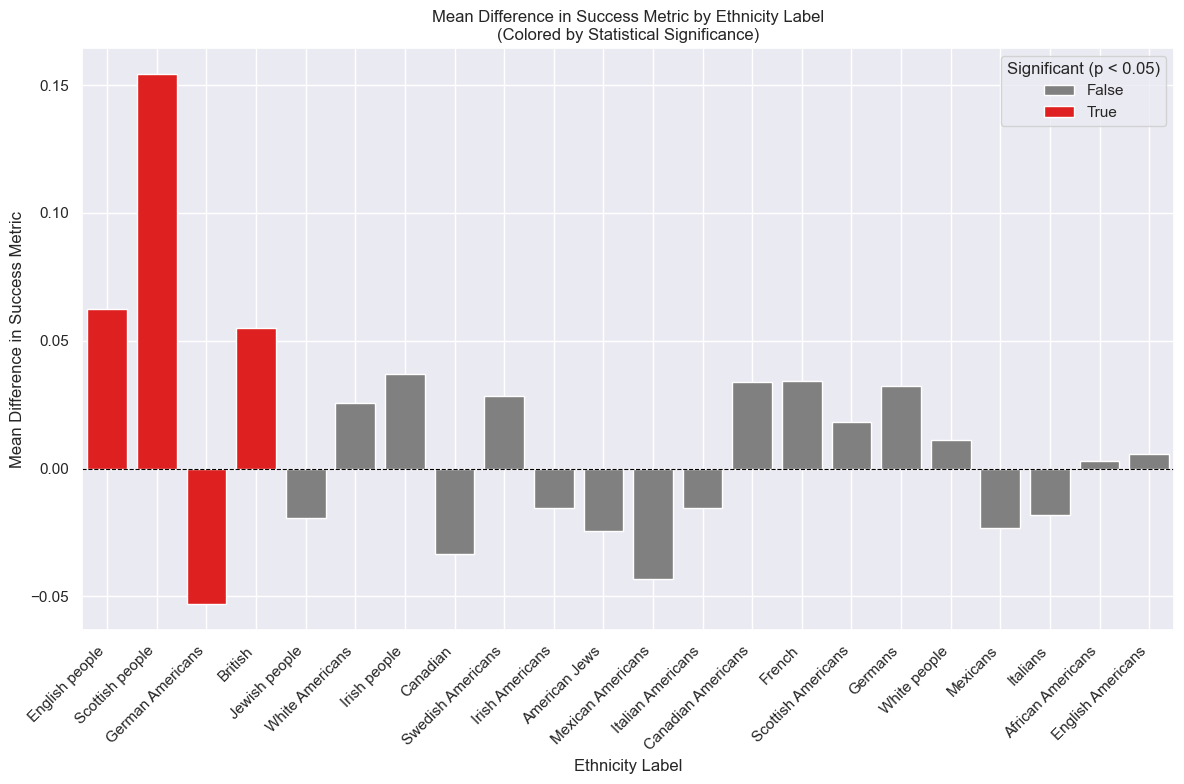

In [39]:

merged_df = pd.merge(results_df, ethnicity_df[['ethnic_cat', 'ethnicity_label']], on='ethnic_cat', how='left')
merged_df_clean = merged_df.dropna(subset=['p_value'])
merged_df_clean['Significant'] = merged_df_clean['p_value'] < 0.05

plt.figure(figsize=(12, 8))
sns.barplot(
    data=merged_df_clean,
    x='ethnicity_label', y='mean_diff',
    hue='Significant',
    palette={True: 'red', False: 'gray'}
)

plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.xlabel("Ethnicity Label")
plt.ylabel("Mean Difference in Success Metric")
plt.title("Mean Difference in Success Metric by Ethnicity Label\n(Colored by Statistical Significance)")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Significant (p < 0.05)")
plt.grid(True)
plt.tight_layout()
plt.show()


# Investigating correlation between Actress' Height, Age and Movie's success metrics

First, let's try to see if there seem to be any link between the actress's age and the Movie Success Score with only looking at the scatter plot.

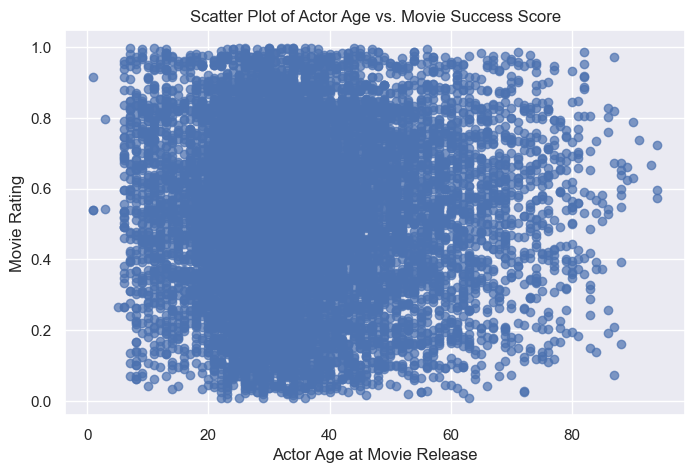

In [40]:
# Example data
x = analysis['actor_age_movie_released']
y = analysis['SuccessMetric']

# Basic scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.7)
plt.xlabel("Actor Age at Movie Release")
plt.ylabel("Movie Rating")
plt.title("Scatter Plot of Actor Age vs. Movie Success Score")
plt.grid(True)
plt.show()

In [41]:
ages = mean_women_data['mean_age']
success_scores = mean_women_data['Rating']

valid_mask = ~np.isnan(ages) & ~np.isnan(success_scores)

correlation = np.corrcoef(ages[valid_mask], success_scores[valid_mask])[0, 1]

print(f"Correlation between actress age and movie success score: {correlation}")

Correlation between actress age and movie success score: 0.06132554899900309


There is no evident link between the two variables. The correlation is very low, the two variables are not correlated.

Let's look now at the link between the actress's mean age and the Movie Success Score

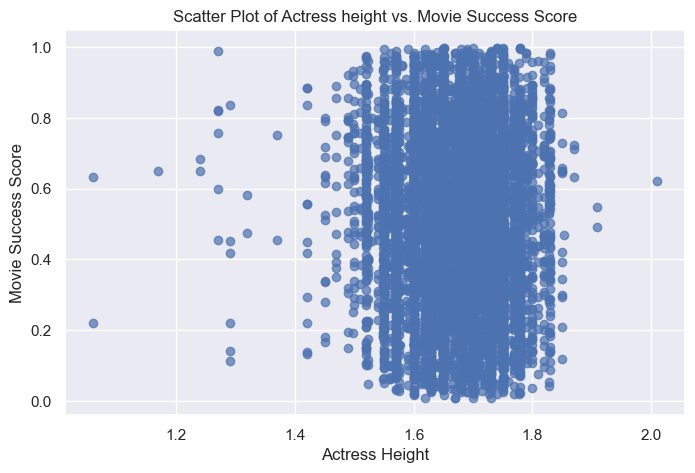

In [42]:
x = analysis['actor_height']
y = analysis['SuccessMetric']

plt.figure(figsize=(8, 5))
plt.scatter(x, y, alpha=0.7)
plt.xlabel("Actress Height")
plt.ylabel("Movie Success Score")
plt.title("Scatter Plot of Actress height vs. Movie Success Score")
plt.grid(True)
plt.show()

In [43]:
ages = mean_women_data['avg_height']
success_scores = mean_women_data['Rating']

valid_mask = ~np.isnan(ages) & ~np.isnan(success_scores)

correlation = np.corrcoef(ages[valid_mask], success_scores[valid_mask])[0, 1]

print(f"Correlation between actress height and movie success score: {correlation}")

Correlation between actress height and movie success score: -0.03934685895688361


There is no evident link between the two variables. The correlation is very low, the two variables are not correlated.

We will now make sure that the two variables are not crosscorrelated.

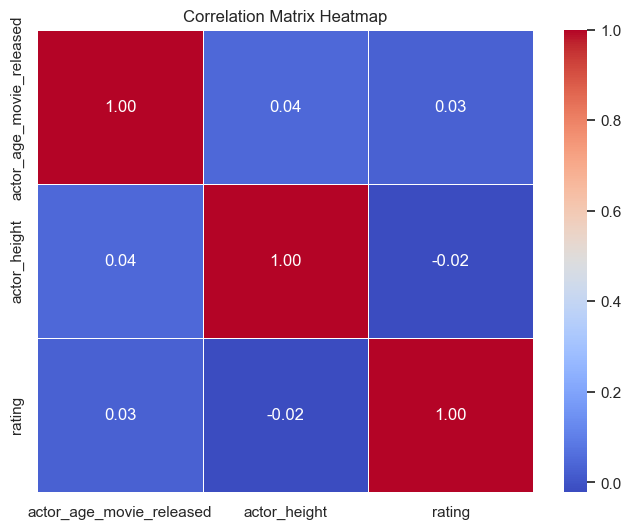

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = analysis[['actor_age_movie_released', 'actor_height', 'rating']].corr()

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()


There is no evident link between the actresses height and age and the success of the movie. We will therefore not be able to include the age and height in the model we first intended to do.

## Tropes correlation

Rather then depicting the real-life women, cinema tends to perpetuate negative gender stereotypes which are reflected in the roles women play in films.
Some of our hypothesis is that women often receive secondary ad stereotypical representation tied to traditional roles of wives, lovers, mothers....
We think also that they are portrayed as overly emotional or dramatic.
We will also try to identify the tropes that leading to the greteast success.


In [51]:
characters = pd.read_csv(data_path + 'character_metadata.csv')
# Parse the JSON strings in the data column of the tropes dataset
tropes['data'] = tropes['data'].apply(ast.literal_eval)
# Normalize the 'data' dictionaries into separate columns
data_expanded = pd.json_normalize(tropes['data'])
# Combine the 'trope' column with the expanded data columns
tropes = pd.concat([tropes['trope'], data_expanded], axis=1)

**Data Enrichment**: Enrichment of the tropes dataset with additional characteristics from the characters dataset (e.g., gender, height, ethnicity, age at release,genre ...)

In [52]:
# Ensure the actor column is named consistently in both DataFrames
characters.rename(columns={'actor_name': 'actor'}, inplace=True)

# Create a dictionary mapping from actor to gender
gender_mapping = characters.set_index('actor')['actor_gender'].to_dict()
height_mapping = characters.set_index('actor')['actor_height'].to_dict()
ethnicity_mapping = characters.set_index('actor')['actor_ethnicity'].to_dict()
age_mapping = characters.set_index('actor')['actor_age_movie_released'].to_dict()

# Use the mapping to add the gender column in tropes based on the actor column
tropes['actor_gender'] = tropes['actor'].map(gender_mapping)
tropes['actor_height'] = tropes['actor'].map(height_mapping)
tropes['actor_ethnicity'] = tropes['actor'].map(ethnicity_mapping)
tropes['actor_age_movie_released'] = tropes['actor'].map(age_mapping)

# Check for the matching column between tropes['id'] and each ID column in characters
matching_column = None
for col in ['character/actor_ID', 'character_ID', 'Actor_ID']:
    if tropes['id'].isin(characters[col]).any():
        matching_column = col
        print(f"Matching column found: {col}")
        break

if matching_column:
    # Perform the merge and directly add the Movie_ID column to the existing tropes DataFrame
    tropes = tropes.merge(
        characters[['Movie_ID', matching_column]],
        left_on='id',
        right_on=matching_column,
        how='left'
    )

# Drop the extra column used for merging if you don’t need it anymore
tropes.drop(columns=[matching_column], inplace=True)

# Rename the Movie_ID column to movie_id in tropes if desired
tropes.rename(columns={'Movie_ID': 'movie_id'}, inplace=True)

# Merge ethnicity label into tropes based on actor_ethnicity and ethnicity_ID
tropes = pd.merge(tropes, ethnicity_df[['ethnicity_ID', 'ethnicity_label']], left_on='actor_ethnicity', right_on='ethnicity_ID', how='left')

# Drop the redundant ethnicity_ID column if it's no longer needed
tropes.drop(columns=['ethnicity_ID'], inplace=True)

# Merge genres into tropes DataFrame based on Movie_ID
tropes = pd.merge(tropes, data_success[['Movie_ID', 'Genres', 'SuccessMetric']], left_on='movie_id', right_on='Movie_ID', how='left')

# Drop redundant column if necessary
tropes.drop(columns=['Movie_ID'], inplace=True)

# Display the updated DataFrame
tropes.head()

Matching column found: character/actor_ID


,trope,char,movie,id,actor,actor_gender,actor_height,actor_ethnicity,actor_age_movie_released,movie_id,ethnicity_label,Genres,SuccessMetric
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams,M,1.702,NaN,37.0,/m/04vcfx,NaN,"[Science Fiction, Fantasy, Comedy, Family Film...",0.487973
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane,M,NaN,NaN,35.0,/m/0557n3,NaN,NaN,NaN
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen,M,1.800,NaN,63.0,/m/0fjjjh,NaN,"[Thriller, Crime Fiction, Supernatural, Superh...",0.417265
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn,M,NaN,NaN,NaN,/m/02vt5c,NaN,"[Natural horror films, Science Fiction, Horror...",0.414449
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader,M,1.780,NaN,40.0,/m/070g7,NaN,"[Thriller, Science Fiction, Action, Sci-Fi Adv...",0.799887


**Filter**: seperate female characters from mens

In [53]:
tropes_w = tropes.loc[tropes['actor_gender'] =='F']

In [54]:
tropes_m = tropes.loc[tropes['actor_gender'] =='M']

**Calculating descriptive statistics**

In [55]:
tropes_w['trope'].describe()

count              69
unique             21
top       dumb_blonde
freq               10
Name: trope, dtype: object

In [56]:
tropes_m['trope'].describe()

count                   431
unique                   65
top       crazy_jealous_guy
freq                     25
Name: trope, dtype: object

There is a higher variety of tropes for male characters (65 unique versus 21 for female characters), and while "dumb_blonde" is the most frequent trope for women, "crazy_jealous_guy" dominates the male tropes in terms of frequency. The women in this dataset is additionaly underepresented, but we will continue to further analyze the distribution of each trope and compare between women and men.

**Distribution of each trope for both women and men, to see which tropes are more frequently associeted with each gender**

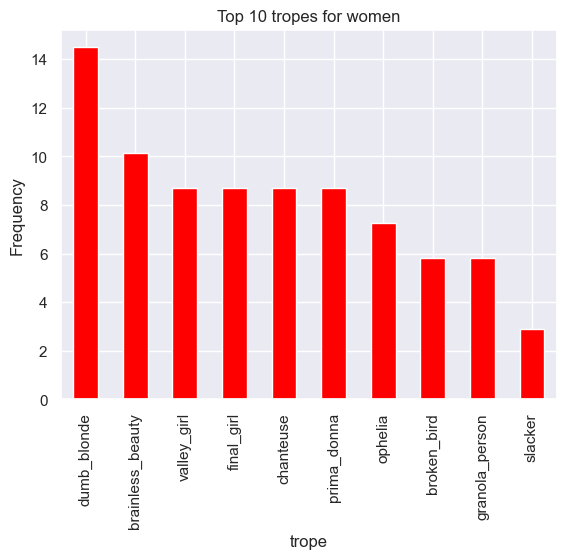

In [57]:
tropes_w_distribution = tropes_w['trope'].value_counts(normalize=True) * 100
tropes_m_distribution = tropes_m['trope'].value_counts(normalize=True) * 100
top_tropes_w = tropes_w_distribution.head(10)
top_tropes_m = tropes_m_distribution.head(10)

# Plotting the top 10 tropes for women and men
top_tropes_w.plot(kind='bar', title='Top 10 tropes for women', color='red')
plt.ylabel('Frequency')
plt.show()

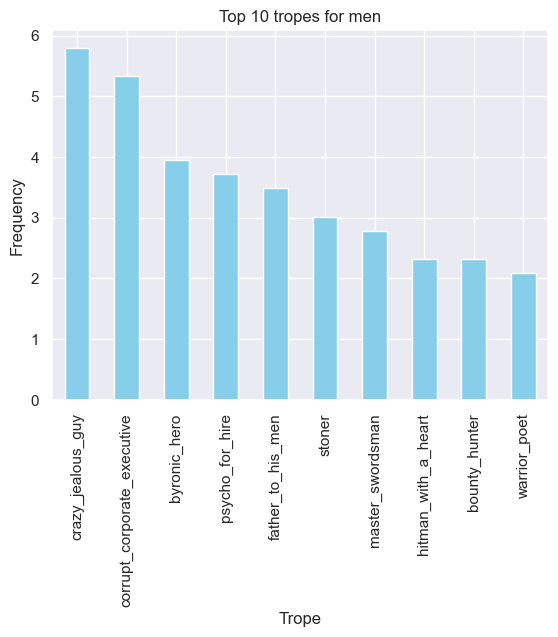

In [58]:
# Plot the top 10 tropes for men
top_tropes_m.plot(kind='bar', title = 'Top 10 tropes for men',color='skyblue')
plt.ylabel('Frequency')
plt.xlabel('Trope')
plt.show()

**Most frequent tropes in cinema for female characters**: As expected the cinema frequently relies on stereotypical portrayals that reinforce traditional gender biases. Tropes like "dumb_blonde," "brainless_beauty," "valley_girl," and "prima_donna" dominate, emphasizing superficial or appearance-focused qualities, which align with stereotypes that reduce women to their looks or perceived lack of intelligence.
Emotionally charged roles, such as "ophelia," "broken_bird," and "chanteuse," suggest that women are often portrayed as overly emotional, fragile, or in need of rescue, reinforcing the notion that women lack emotional stability or independence. Thus, female characters are more often defined by their personalities or relationships rather than ambition, skills, or leadership. 

**Chi-square test for gender and trope association**: Let's see if the gender and trope type are independent of each other.

In [59]:
# Create contingency table
contingency_table = pd.crosstab(tropes['actor_gender'], tropes['trope'])
chi2, p, dof, expected = chi2_contingency(contingency_table)

print("Chi-square Test:")
print("Chi2 Statistic:", chi2)
print("P-value:", p)

Chi-square Test:
Chi2 Statistic: 369.8513527525936
P-value: 5.592160386860096e-42


The Chi-square statistic of 370.63 indicates a strong deviation from the expected frequency distribution of the tropes between different genders. The very small p-value (close to 0) suggests that the result is statistically significant, meaning there is a highly significant association between the gender of the actor and the trope they portray. This means that the distribution of tropes across genders is not due to random chance, but rather there is a clear relationship between the two variables.

**Average age of actors by tropes**: to see if certain tropes are associated with different age groupes

/var/folders/_l/bp6t546s7f9dfbzwx58vjhbw0000gn/T/ipykernel_6706/1664047801.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tropes_w['age_group'] = pd.cut(tropes['actor_age_movie_released'], bins=age_bins, labels=age_labels)
/var/folders/_l/bp6t546s7f9dfbzwx58vjhbw0000gn/T/ipykernel_6706/1664047801.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tropes_m['age_group'] = pd.cut(tropes['actor_age_movie_released'], bins=age_bins, labels=age_labels)
/var/folders/_l/bp6t546s7f9dfbzwx58vjhbw0000gn/T/ipykern

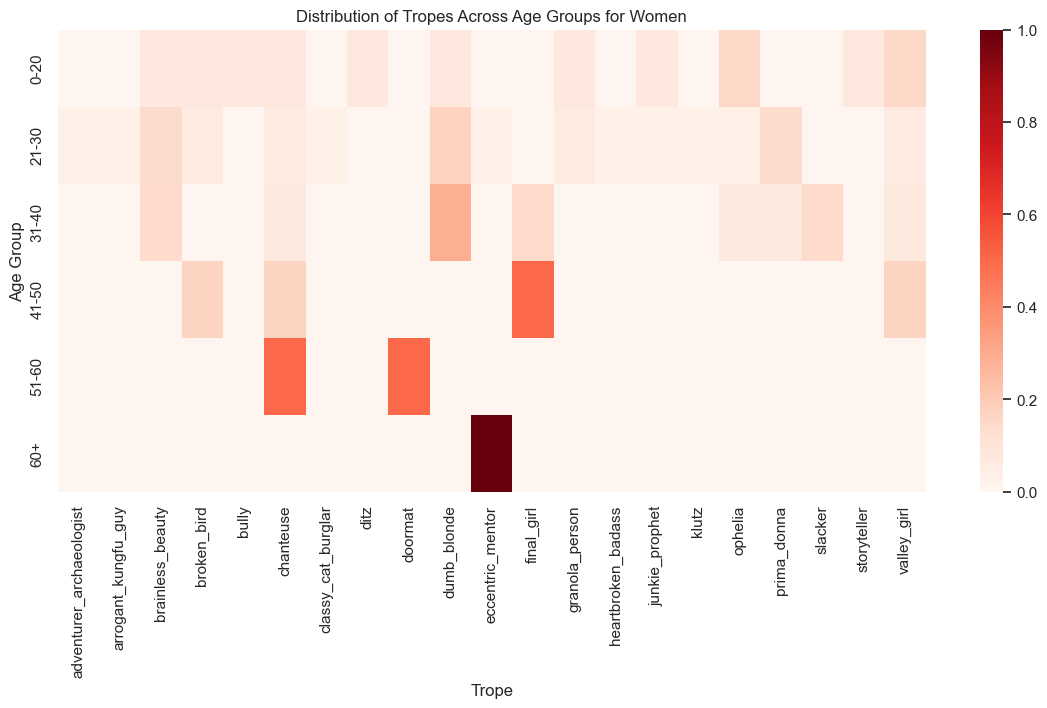

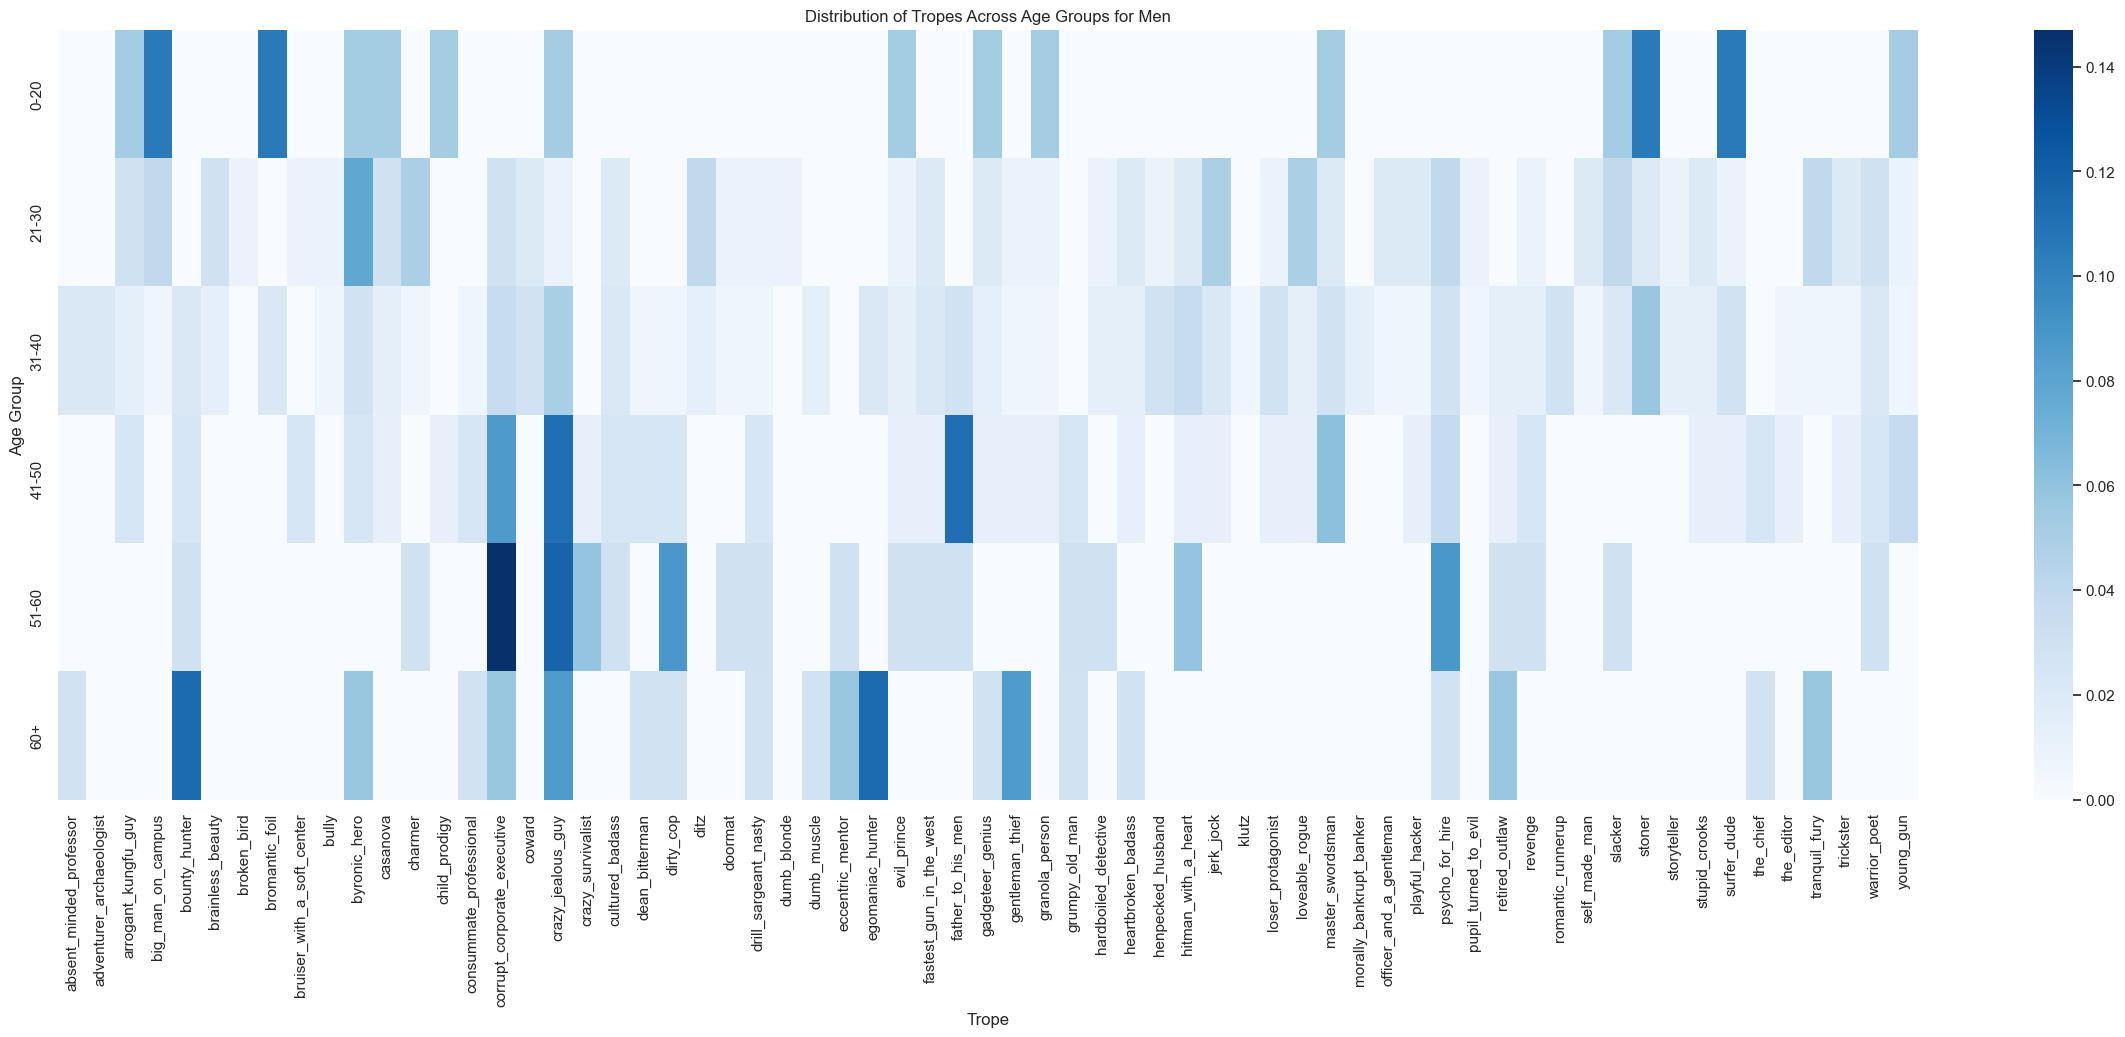

In [60]:
# Categorize age into groups
age_bins = [0, 20, 30, 40, 50, 60, 100]
age_labels = ['0-20', '21-30', '31-40', '41-50', '51-60', '60+']
tropes_w['age_group'] = pd.cut(tropes['actor_age_movie_released'], bins=age_bins, labels=age_labels)
tropes_m['age_group'] = pd.cut(tropes['actor_age_movie_released'], bins=age_bins, labels=age_labels)

#  distribution of tropes within each age group
tropes_by_age_group_w = tropes_w.groupby(['age_group', 'trope']).size().unstack(fill_value=0)
tropes_by_age_group_m = tropes_m.groupby(['age_group', 'trope']).size().unstack(fill_value=0)

# normalize within each age group to get the proportion of each trope
tropes_by_age_group_w = tropes_by_age_group_w.div(tropes_by_age_group_w.sum(axis=1), axis=0)
tropes_by_age_group_m = tropes_by_age_group_m.div(tropes_by_age_group_m.sum(axis=1), axis=0)


plt.figure(figsize=(14, 6))
sns.heatmap(tropes_by_age_group_w, cmap='Reds', annot=False, fmt=".2f")
plt.title("Distribution of Tropes Across Age Groups for Women")
plt.xlabel("Trope")
plt.ylabel("Age Group")
plt.show()

plt.figure(figsize=(30, 10))
sns.heatmap(tropes_by_age_group_m, cmap='Blues', annot=False, fmt=".2f")
plt.title("Distribution of Tropes Across Age Groups for Men")
plt.xlabel("Trope")
plt.ylabel("Age Group")
plt.show()

**Average height by trope**: to see if certain tropes are associated with a certain range of height

/var/folders/_l/bp6t546s7f9dfbzwx58vjhbw0000gn/T/ipykernel_6706/2696179964.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tropes_w['height_group'] = pd.cut(tropes_w['actor_height'], bins=height_bins_women, labels=height_labels_women)
/var/folders/_l/bp6t546s7f9dfbzwx58vjhbw0000gn/T/ipykernel_6706/2696179964.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tropes_m['height_group'] = pd.cut(tropes_m['actor_height'], bins=height_bins_men, labels=height_labels_men)
/var/folders/_l/bp6t546s7f9dfbzwx58vjh

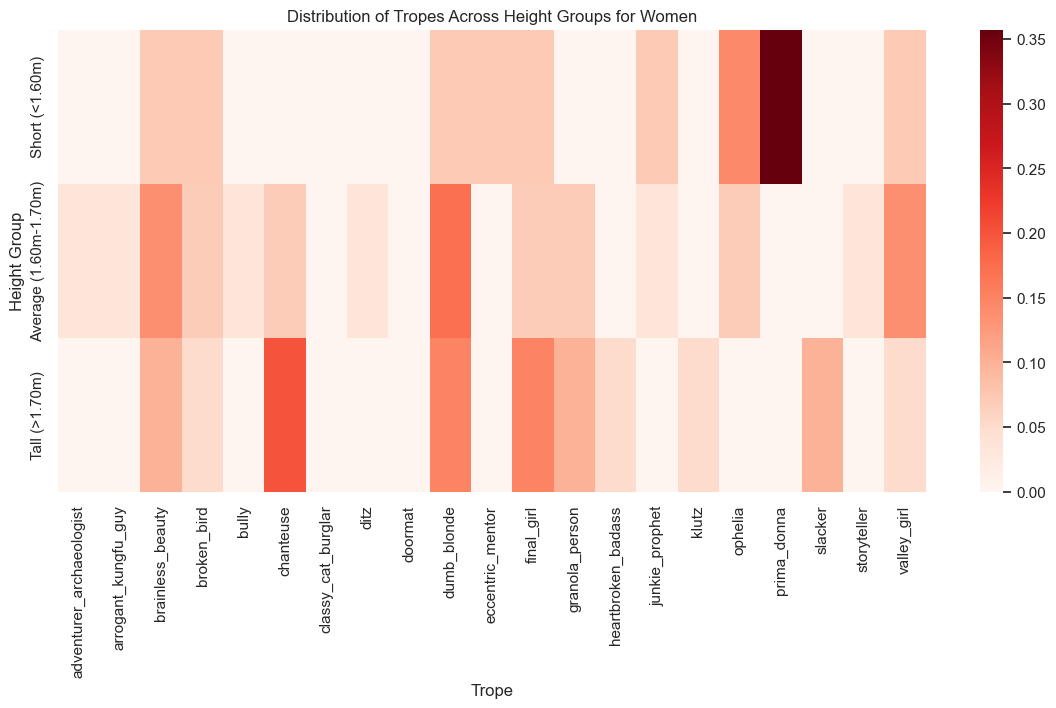

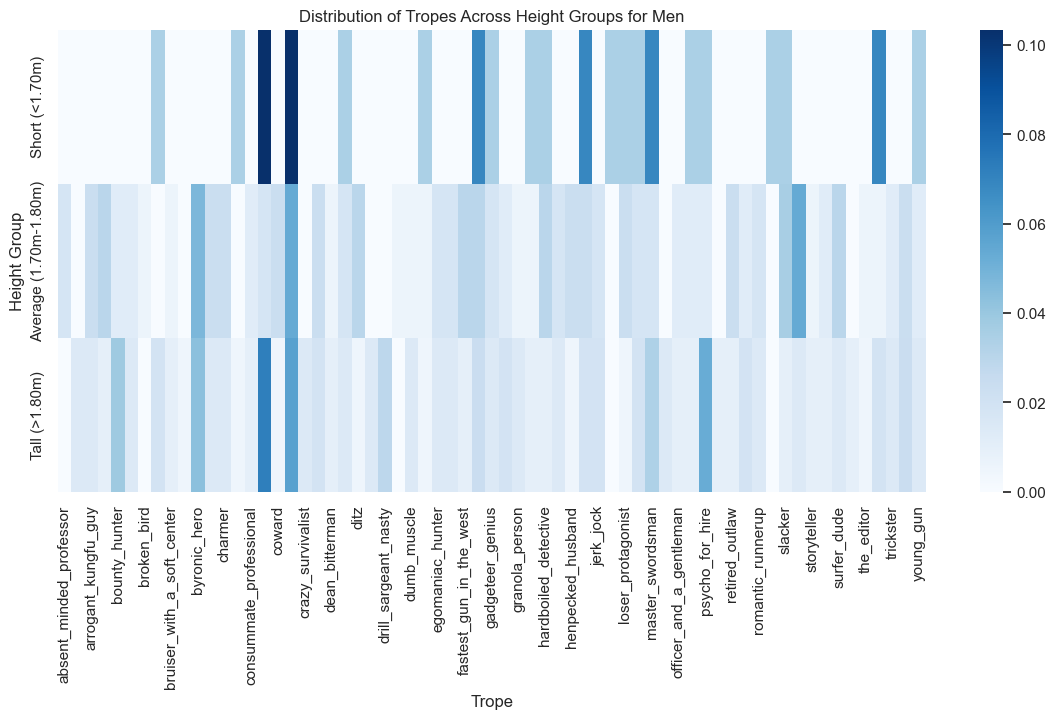

In [61]:
# Define height bins and labels for women
height_bins_women = [0, 1.60, 1.70, float('inf')]
height_labels_women = ['Short (<1.60m)', 'Average (1.60m-1.70m)', 'Tall (>1.70m)']
tropes_w['height_group'] = pd.cut(tropes_w['actor_height'], bins=height_bins_women, labels=height_labels_women)

# Define height bins and labels for men
height_bins_men = [0, 1.70, 1.80, float('inf')]
height_labels_men = ['Short (<1.70m)', 'Average (1.70m-1.80m)', 'Tall (>1.80m)']
tropes_m['height_group'] = pd.cut(tropes_m['actor_height'], bins=height_bins_men, labels=height_labels_men)

# Calculate the distribution of tropes within each height group for women
tropes_by_height_group_w = tropes_w.groupby(['height_group', 'trope']).size().unstack(fill_value=0)
tropes_by_height_group_w = tropes_by_height_group_w.div(tropes_by_height_group_w.sum(axis=1), axis=0)

# Calculate the distribution of tropes within each height group for men
tropes_by_height_group_m = tropes_m.groupby(['height_group', 'trope']).size().unstack(fill_value=0)
tropes_by_height_group_m = tropes_by_height_group_m.div(tropes_by_height_group_m.sum(axis=1), axis=0)

plt.figure(figsize=(14, 6))
sns.heatmap(tropes_by_height_group_w, cmap='Reds', annot=False, fmt=".2f")
plt.title("Distribution of Tropes Across Height Groups for Women")
plt.xlabel("Trope")
plt.ylabel("Height Group")
plt.show()

plt.figure(figsize=(14, 6))
sns.heatmap(tropes_by_height_group_m, cmap='Blues', annot=False, fmt=".2f")
plt.title("Distribution of Tropes Across Height Groups for Men")
plt.xlabel("Trope")
plt.ylabel("Height Group")
plt.show()

By analyzing this data, we can gain insights into how a woman's age might correlate with the types of roles she is portrayed in. Additionally, we could extend this analysis by examining how characteristics such as height might also influence the likelihood of a woman being assigned certain tropes, offering a more nuanced understanding of gender-based portrayals in cinema.


**Let's focus on women**

/var/folders/_l/bp6t546s7f9dfbzwx58vjhbw0000gn/T/ipykernel_6706/3200704949.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tropes_w['trope_code'] = tropes_w['trope'].astype('category').cat.codes


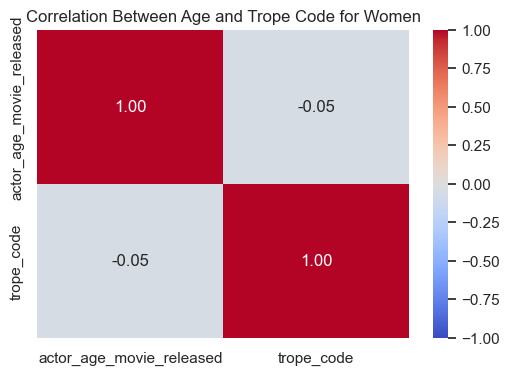

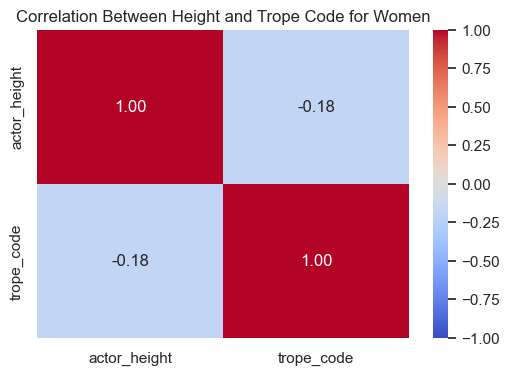

In [62]:
# Encode tropes numerically :assigning each trope a unique integer
tropes_w['trope_code'] = tropes_w['trope'].astype('category').cat.codes

# correlation between actor age and trope code 
correlation_age_trope_w = tropes_w[['actor_age_movie_released', 'trope_code']].corr()

# correlation between actor height and trope code for women
correlation_height_trope_w = tropes_w[['actor_height', 'trope_code']].corr()

# heatmap for Age and Trope Code Correlation 
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_age_trope_w, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Between Age and Trope Code for Women")
plt.show()

# heatmap for Height and Trope Code Correlation
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_height_trope_w, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Between Height and Trope Code for Women")
plt.show()

The correlation between height and trope is -0.18 and correlation between the actrice age and her tropeis -0.05 indicating a weak negative correlation,meaning that age and height are not strongly related in the dataset. In other words, a person's height does not significantly change with age in this dataset.

**Ethnicity Distribution by Trope**

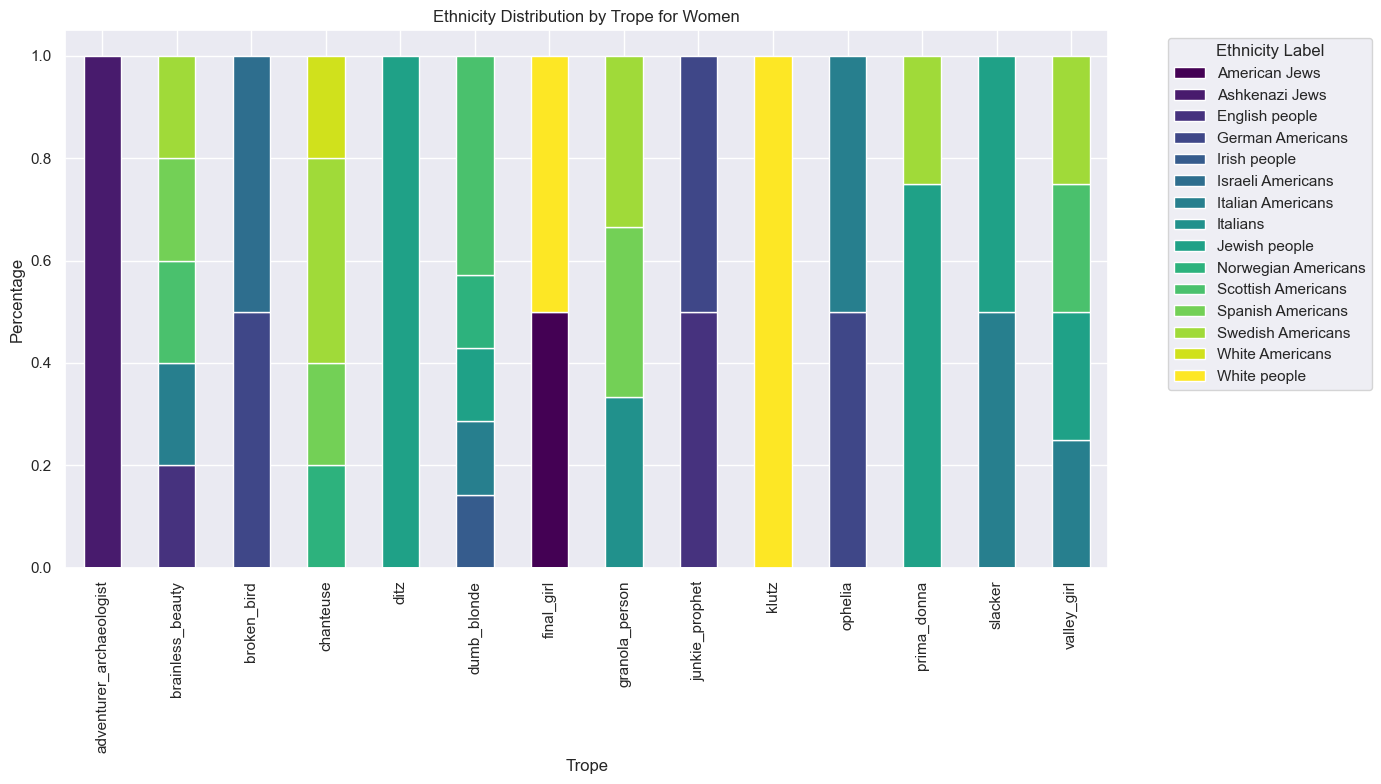

In [63]:
# Calculate the normalized distribution of ethnicity labels per trope for women
ethnicity_distribution_w = tropes_w.groupby('trope')['ethnicity_label'].value_counts(normalize=True).unstack().fillna(0)

ethnicity_distribution_w.plot(kind='bar', stacked=True, figsize=(14, 8), colormap='viridis')
plt.title("Ethnicity Distribution by Trope for Women")
plt.xlabel("Trope")
plt.ylabel("Percentage")
plt.legend(title="Ethnicity Label", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Correlation between women trope and the success of a movie

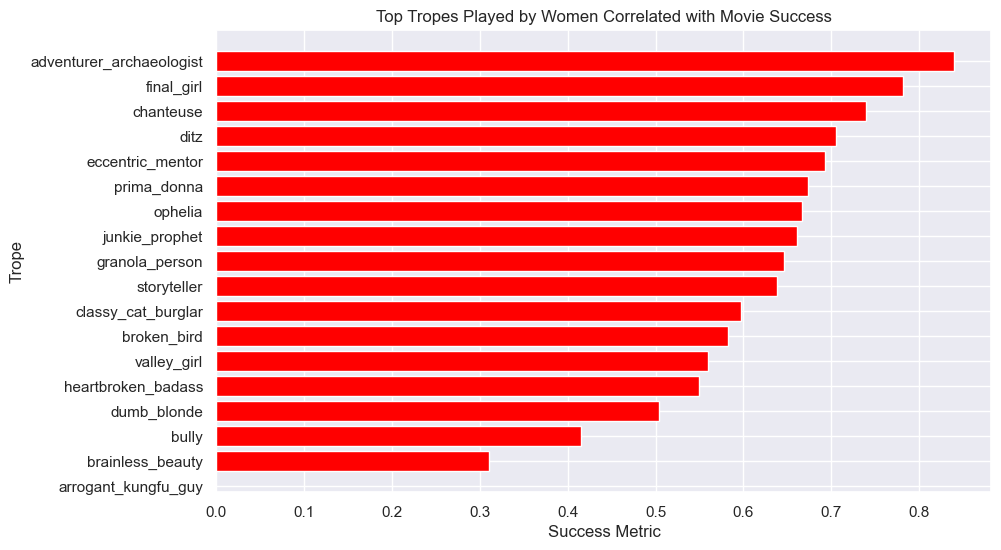

In [64]:
# Group by trope and calculate the average success for each trope
trope_success = tropes_w.groupby('trope')['SuccessMetric'].mean().reset_index()
# Calculate the correlation between each trope's success metric and movie success
correlation = trope_success['SuccessMetric'].corr(tropes_w['SuccessMetric'])

# Display tropes associated with high success
top_tropes = trope_success.sort_values(by='SuccessMetric', ascending=False)
plt.figure(figsize=(10, 6))
plt.barh(top_tropes['trope'], top_tropes['SuccessMetric'], color='red')
plt.xlabel('Success Metric')
plt.ylabel('Trope')
plt.title('Top Tropes Played by Women Correlated with Movie Success')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()

### Regression analysis: Measure how much each trope contributes to the success metric, even when other factors are considered.
For example, an "adventurous" trope might perform better in action genres, or characters of certain ages or ethnic backgrounds might resonate more with audiences in particular tropes. By including these variables, regression helps us understand whether success depends on a combination of these factors.

**Is the relationship statistically significant?** A significant result suggests that the observed effect of a trope, genre and ethnicity on success is unlikely to be due to chance, giving us more confidence in our findings.

In [68]:
import statsmodels.api as sm

# Drop rows with missing values in SuccessMetric, actor_age_movie_released, or ethnicity_label if necessary
tropes_w_exploded = tropes_w.explode('Genres')
tropes_w_exploded = tropes_w_exploded.dropna(subset=['SuccessMetric', 'actor_age_movie_released', 'ethnicity_label'])

# One-hot encode genres, tropes, and ethnicity labels
genre_encoded = pd.get_dummies(tropes_w_exploded['Genres'], prefix='Genre')
trope_encoded = pd.get_dummies(tropes_w_exploded['trope'], prefix='Trope')
ethnicity_encoded = pd.get_dummies(tropes_w_exploded['ethnicity_label'], prefix='Ethnicity')

# Combine all features, including 'actor_age_movie_released' as an independent variable
data_for_regression = pd.concat(
    [tropes_w_exploded[['SuccessMetric', 'actor_age_movie_released']].reset_index(drop=True),
     genre_encoded.reset_index(drop=True),
     trope_encoded.reset_index(drop=True),
     ethnicity_encoded.reset_index(drop=True)],
    axis=1
)

# Define X (independent variables) and y (dependent variable)
X = data_for_regression.drop(columns=['SuccessMetric'])
y = data_for_regression['SuccessMetric']

54

# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit regression model
model = sm.OLS(y, X).fit()

# Extract the model fit summary statistics
model_fit_summary = {
    "R-squared": model.rsquared,
    "Adjusted R-squared": model.rsquared_adj,
    "F-statistic": model.fvalue,
    "Prob (F-statistic)": model.f_pvalue,
    "AIC": model.aic,
    "BIC": model.bic,
    "Log-Likelihood": model.llf,
    "Number of Observations": model.nobs
}
for key, value in model_fit_summary.items():
    print(f"{key}: {value:.3f}")

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [66]:
print(model.summary())

NameError: name 'model' is not defined

**R-squared:**  0.945, the model explains 96.5% of the variance in the SuccessMetric. This suggests that the predictors (genre, tropes, and ethnicity) together provide a strong explanation for movie success.

**Adjusted R-squared:** 0.889, this high value accounts for the number of predictors in the model, suggesting that even with many predictors, the model is robust.

**Durbin-Watson:** 0.873, which suggests possible positive autocorrelation in the residuals. Ideally, this should be closer to 2 for no autocorrelation.
Condition Number: 2.01e+18, which is very high, indicating potential multicollinearity. This suggests that some predictor variables may be highly correlated with each other.

**P-values and Significance:** The coefficients with a p-value less than 0.05 are statistically significant, suggesting a reliable effect on the SuccessMetric.

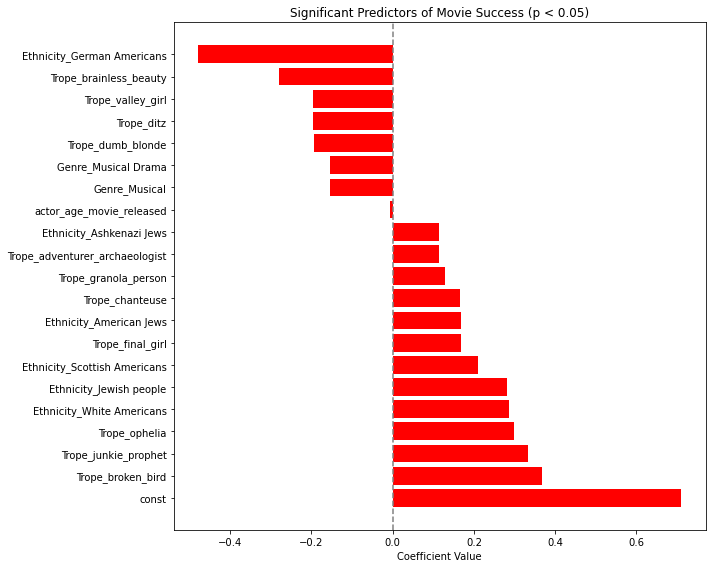

In [75]:
# Get the significant variables from the model summary
significant_vars = model.summary2().tables[1]
significant_vars = significant_vars[significant_vars['P>|t|'] < 0.05]

# Sort by the absolute value of the coefficients for better visualization
significant_vars = significant_vars.sort_values(by='Coef.', ascending=False)


plt.figure(figsize=(10, 8))
plt.barh(significant_vars.index, significant_vars['Coef.'], color='red')
plt.xlabel('Coefficient Value')
plt.title('Significant Predictors of Movie Success (p < 0.05)')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


Each bar in the plot corresponds to the coefficient for a specific variable (like Ethnicity_White Americans, Tope_dumb_blonde, etc.).
Positive coefficients push the SuccessMetric higher (more successful movie).
Negative coefficients suggest a negative relationship, meaning an increase in that variable could decrease the SuccessMetric.

### Next step
Currently, the dataset have a limited number of tropes per movie, and a limited number of actrices per trope leading to a less precise analysis. To improve this, we will search for additional sources of trope data. 
With a broader and more diverse set of tropes, the correlations between the types of tropes associated with women in movies and movie success (e.g., box office revenue, critical reception, awards) will be more accurate. 
To do so we have found to additiional dataframes that are extracted from the TVTropes page for movie and we aim to merge them together. 
We have found these two datasets that contain the following relevant columns:

The **list_movies.csv**:
* eligibleTitle: The title of the movie.
* link: The URL to the movie's TVTropes page.
* searchYear, oscarsYear: The year the movie was released.
* matchname: A processed version of the title combined with the year for matching.
* tconst: The IMDb ID.
* genres: The genres of the movie.
* winner: Whether the movie was an Oscar winner (1 for yes, 0 for no).
* id: A unique identifier for each movie.

The **list_tropes.csv** :
* tropeid: A unique identifier for each trope (e.g., tr00001).
* tropename: The name of the trope (e.g., 0% Approval Rating).
* tropefreq: The frequency of the trope across all movies (e.g., 36).
* tropelink: A link or identifier that points to the trope's page (e.g., * ZeroPercentApprovalRating).
* tropefreq2000: The frequency of the trope since the year 2000 (e.g., 20).

Using the link column in list_movies.csv, which contains the TVTropes URL, we'll extract the associated tropes for each movie and merge the tropes with the movies based on the link column to associate each movie with its respective tropes.

The dataset where taken from an old project found on git hub: https://github.com/dw-data/movie-tropes/blob/master/datasets/list_tropes.csv